In [1]:
# Import libraries
import datetime as dt
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import climdex.precipitation as pdex
import climdex.temperature as tdex

%matplotlib inline

In [3]:
# Plot

def myPlot(data):
    projection = ccrs.Mercator()
    crs = ccrs.PlateCarree()

    plt.figure(figsize=(16,9), dpi=300)
    ax = plt.axes(projection=projection, frameon=True)
    gl = ax.gridlines(
        crs=crs,
        draw_labels=True,
        linewidth=.6,
        color='gray',
        alpha=0.5,
        linestyle='-.'
    )
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}

    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    cbar_kwargs = {
        'orientation':'horizontal',
        'shrink':0.6,
        "pad":.05,
        'aspect':40,
    }

    data.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs=cbar_kwargs,
        levels=21
    )

    ax.set_extent(
        [45, 65, 25, 40],
        crs=crs
    )

    return plt.show()

In [4]:
# Load data as a "xarray.Dataset"
data = xr.open_dataset('data.nc')

data

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 55152, lon: 57, lat: 41)
Coordinates:
  * time     (time) datetime64[ns] 441kB 1950-01-01 1950-01-02 ... 2100-12-31
  * lon      (lon) float64 456B 51.12 51.25 51.38 51.5 ... 57.88 58.0 58.12
  * lat      (lat) float64 328B 30.12 30.25 30.38 30.5 ... 34.88 35.0 35.12
Data variables:
    pr       (time, lat, lon) float32 516MB ...
    tasmax   (time, lat, lon) float32 516MB ...
    tasmin   (time, lat, lon) float32 516MB ...
Attributes: (12/17)
    CDI:             Climate Data Interface version 2.0.5 (https://mpimet.mpg...
    Conventions:     CF=1.6
    institution:     Department of Civil and Environmental Engineering, Weste...
    title:           MBC Bias Corrected Data for CanESM5_ssp245
    frequency:       day
    contact:         mrahimim@uwo.ca, fjalilip@uwo.ca, mnajafi7@uwo.ca
    ...              ...
    bc_observation:  Interpolated observation. 2021 - A spatially comprehensi...
    bc_info:         UWOECC-MBCn-Iran-1950-2100
    bc_period:       1950-2100
    spatial_domain:  Iran
    history:         Mon Feb 26 14:33:24 2024: cdo sellonlatbox,51.125,58.125...
    CDO:             Climate Data Operators version 2.0.5 (https://mpimet.mpg...

In [5]:
# Extract coordinates and time as "numpy.ndarray"
lat = data['lat'].data
lon = data['lon'].data
time = data['time'].data

In [6]:
# Extarct Resolution
print(
    "Delta Y: ", (lat[1] - lat[0]), "Degrees\n"
    "Delta X: ", (lon[1] - lon[0]), "Degrees\n"
    "Delta T: ", (time[1] - time[0]).astype('timedelta64[D]').astype(int), "Days"
)

Delta Y:  0.125 Degrees
Delta X:  0.125 Degrees
Delta T:  1 Days


In [7]:
# Extract variables names as a "list"
var_list = list(data.data_vars)
print("variables as a list:", var_list)

variables as a list: ['pr', 'tasmax', 'tasmin']


In [8]:
# Extract variables data as "xarray.DataArray"
dh_start = '1984-01-01'
dh_end   = '2015-12-31'
df_start = '2071-01-01'
df_end   = '2100-12-31'

pr = data["pr"]
pr_1984_2015 = pr.sel(time=slice(dh_start, dh_end))
pr_2071_2100 = pr.sel(time=slice(df_start, df_end))

tasmax = data["tasmax"]
tasmax_1984_2015 = tasmax.sel(time=slice(dh_start, dh_end))
tasmax_2071_2100 = tasmax.sel(time=slice(df_start, df_end))

tasmin = data["tasmin"]
tasmin_1984_2015 = tasmin.sel(time=slice(dh_start, dh_end))
tasmin_2071_2100 = tasmin.sel(time=slice(df_start, df_end))

In [9]:
pr

<xarray.DataArray 'pr' (time: 55152, lat: 41, lon: 57)> Size: 516MB
[128890224 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 441kB 1950-01-01 1950-01-02 ... 2100-12-31
  * lon      (lon) float64 456B 51.12 51.25 51.38 51.5 ... 57.88 58.0 58.12
  * lat      (lat) float64 328B 30.12 30.25 30.38 30.5 ... 34.88 35.0 35.12
Attributes:
    standard_name:  precipitation_flux
    long_name:      Bias-Adjusted Precipitation
    units:          mm

# Calculate Rx1day (1984-2015)

In [10]:
indices = pdex.indices(time_dim='time')
rx1day_1984_2015 = indices.monthly_rx1day(pr_1984_2015, varname='pr')
rx1day_1984_2015_climatology = rx1day_1984_2015.mean(dim='time')
rx1day_1984_2015_climatology.name = "rx1day 1984-2015 (mm) (30-year Climatology)"
rx1day_1984_2015_anomaly = (rx1day_1984_2015 - rx1day_1984_2015_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


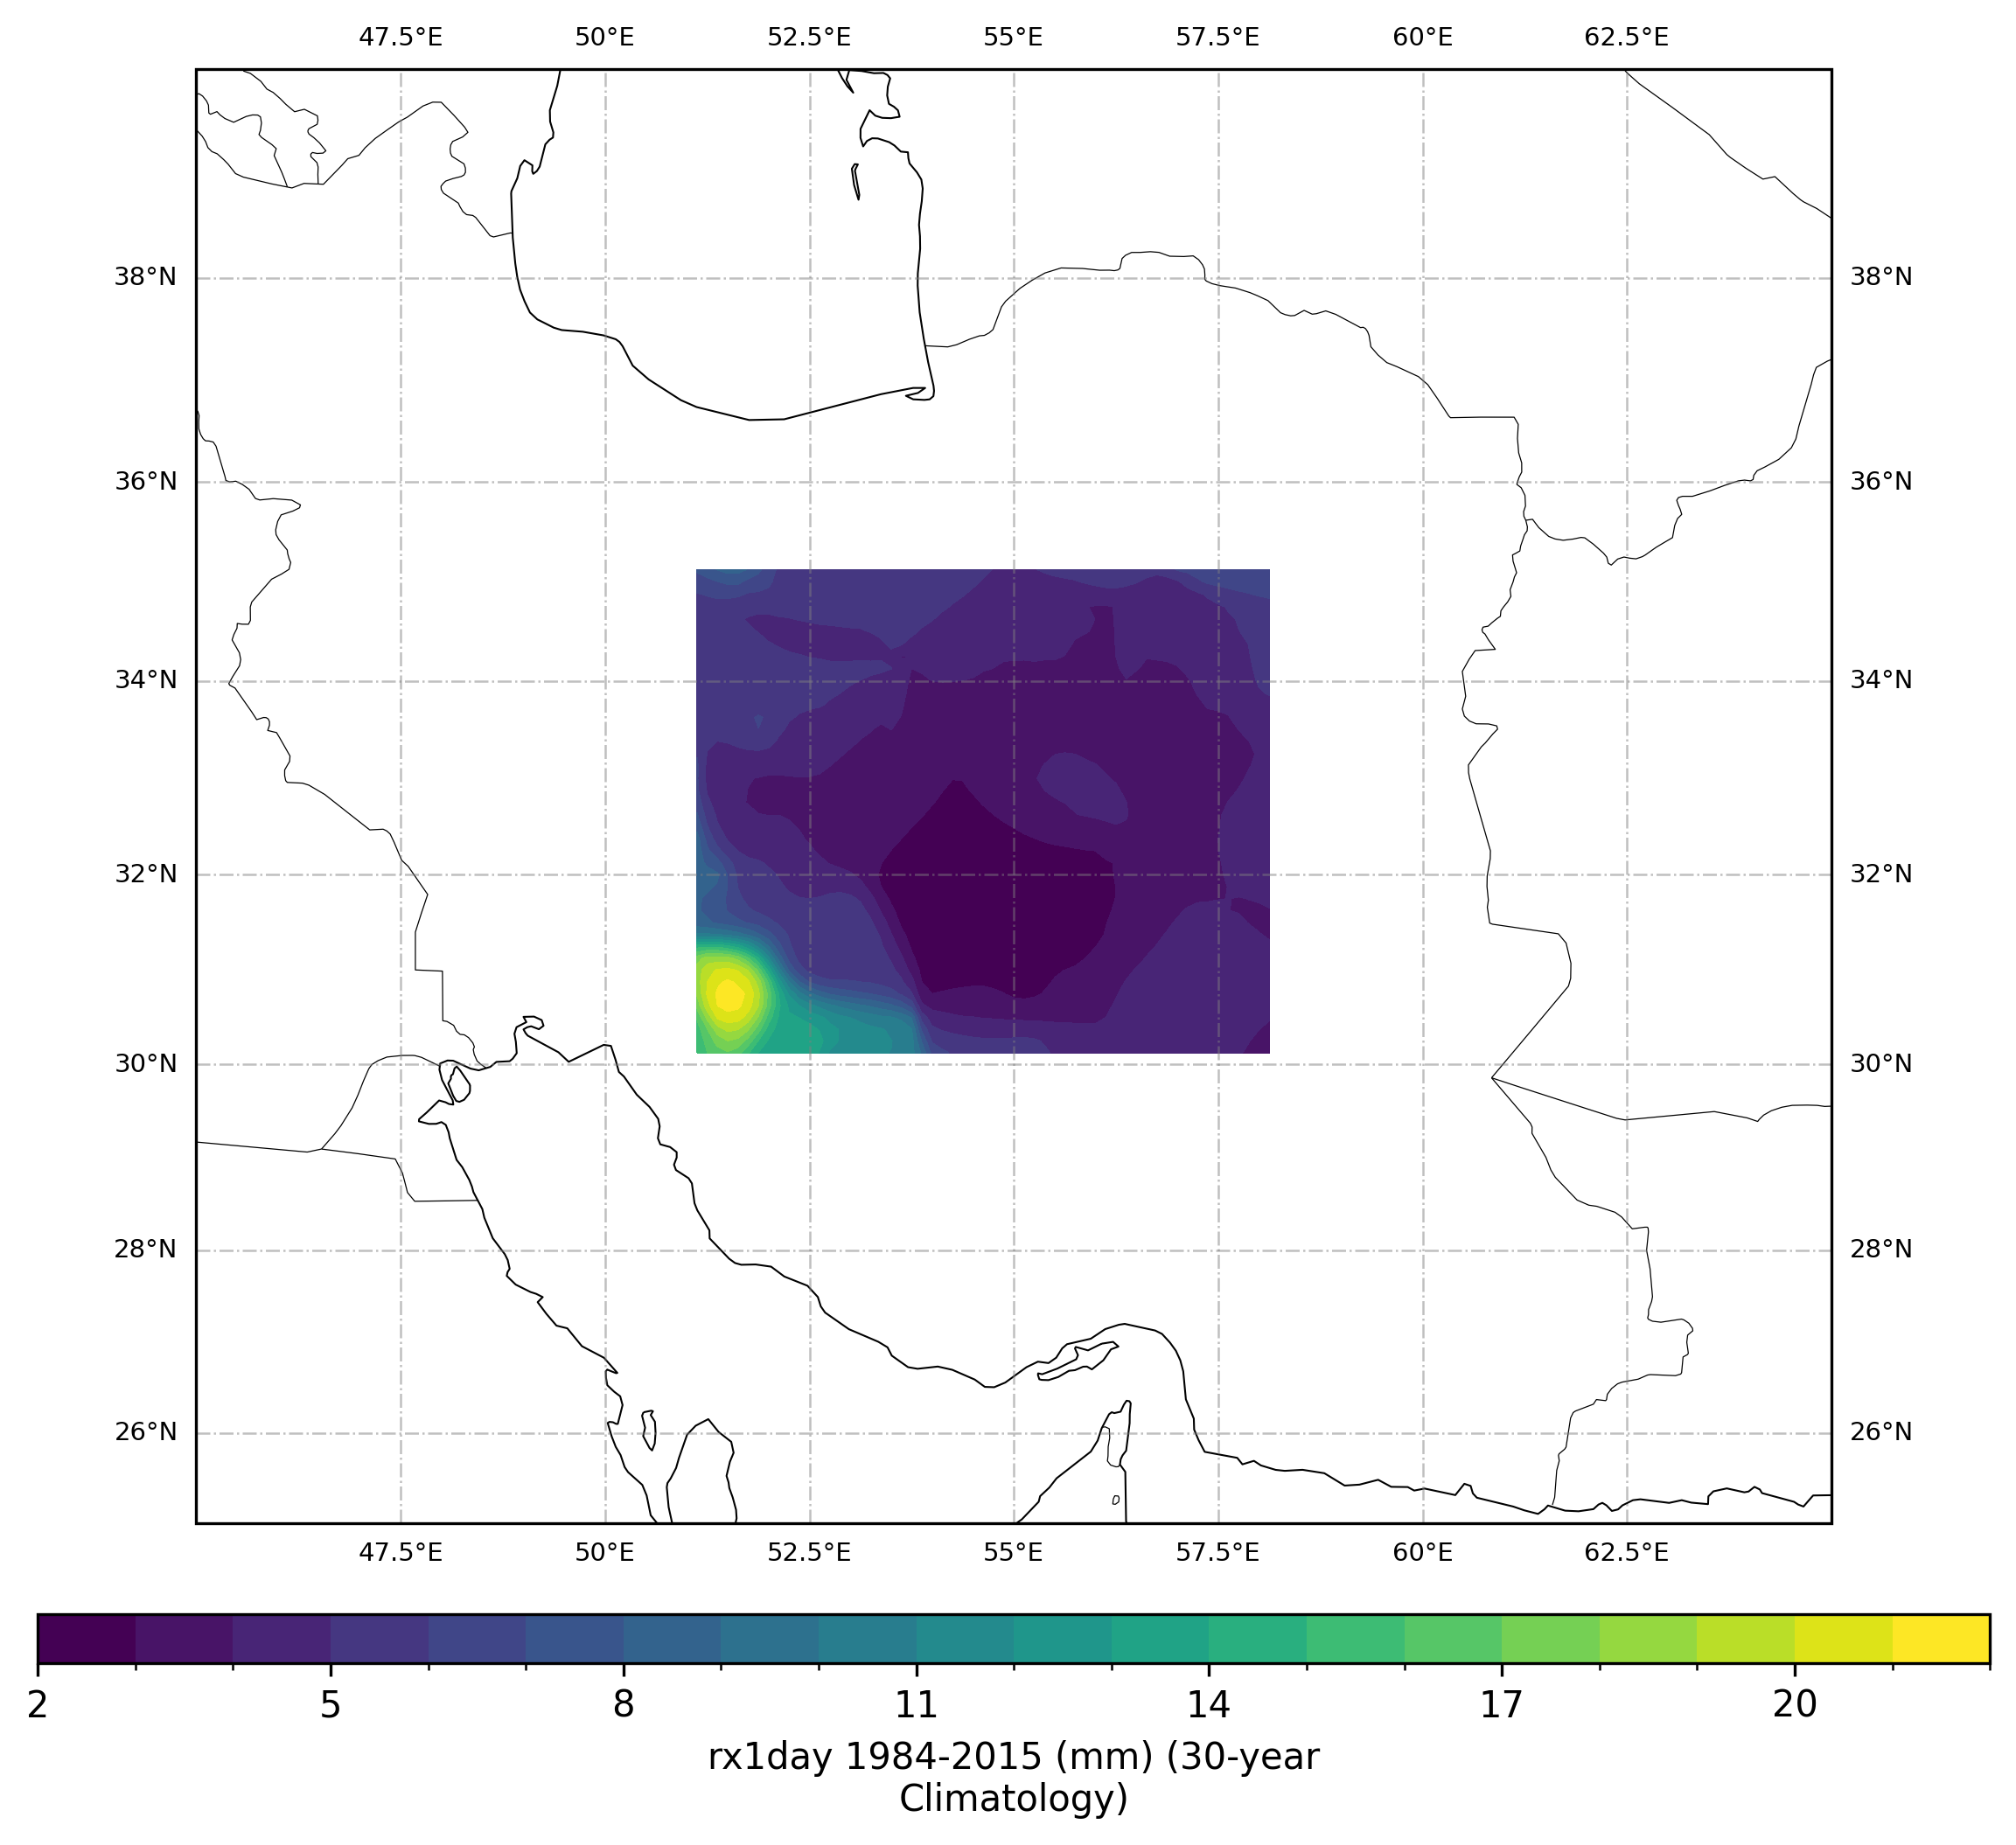

In [11]:
myPlot(rx1day_1984_2015_climatology)

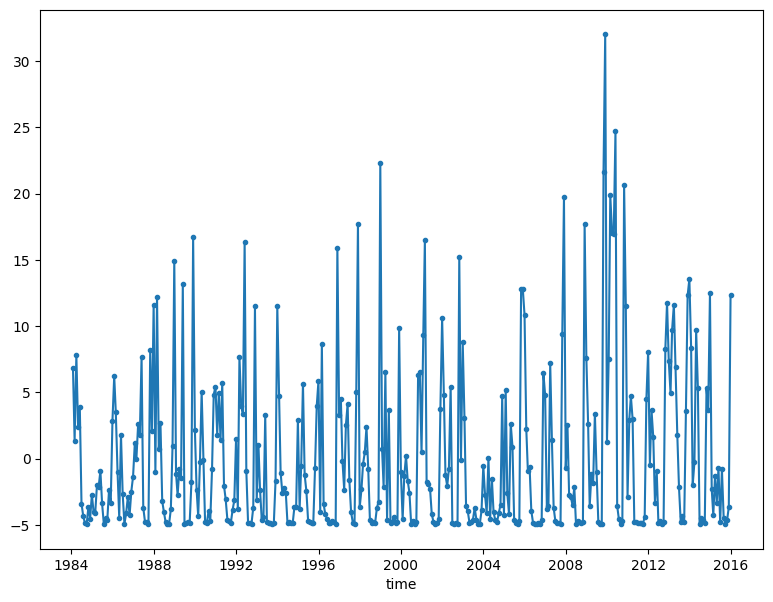

In [12]:
rx1day_1984_2015_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate Rx1day (2071-2100)

In [13]:
indices = pdex.indices(time_dim='time')
rx1day_2071_2100 = indices.monthly_rx1day(pr_2071_2100, varname='pr')
rx1day_2071_2100_climatology = rx1day_2071_2100.mean(dim='time')
rx1day_2071_2100_climatology.name = "rx1day 2071-2100 (mm) (30-year Climatology)"
rx1day_2071_2100_anomaly = (rx1day_2071_2100 - rx1day_2071_2100_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


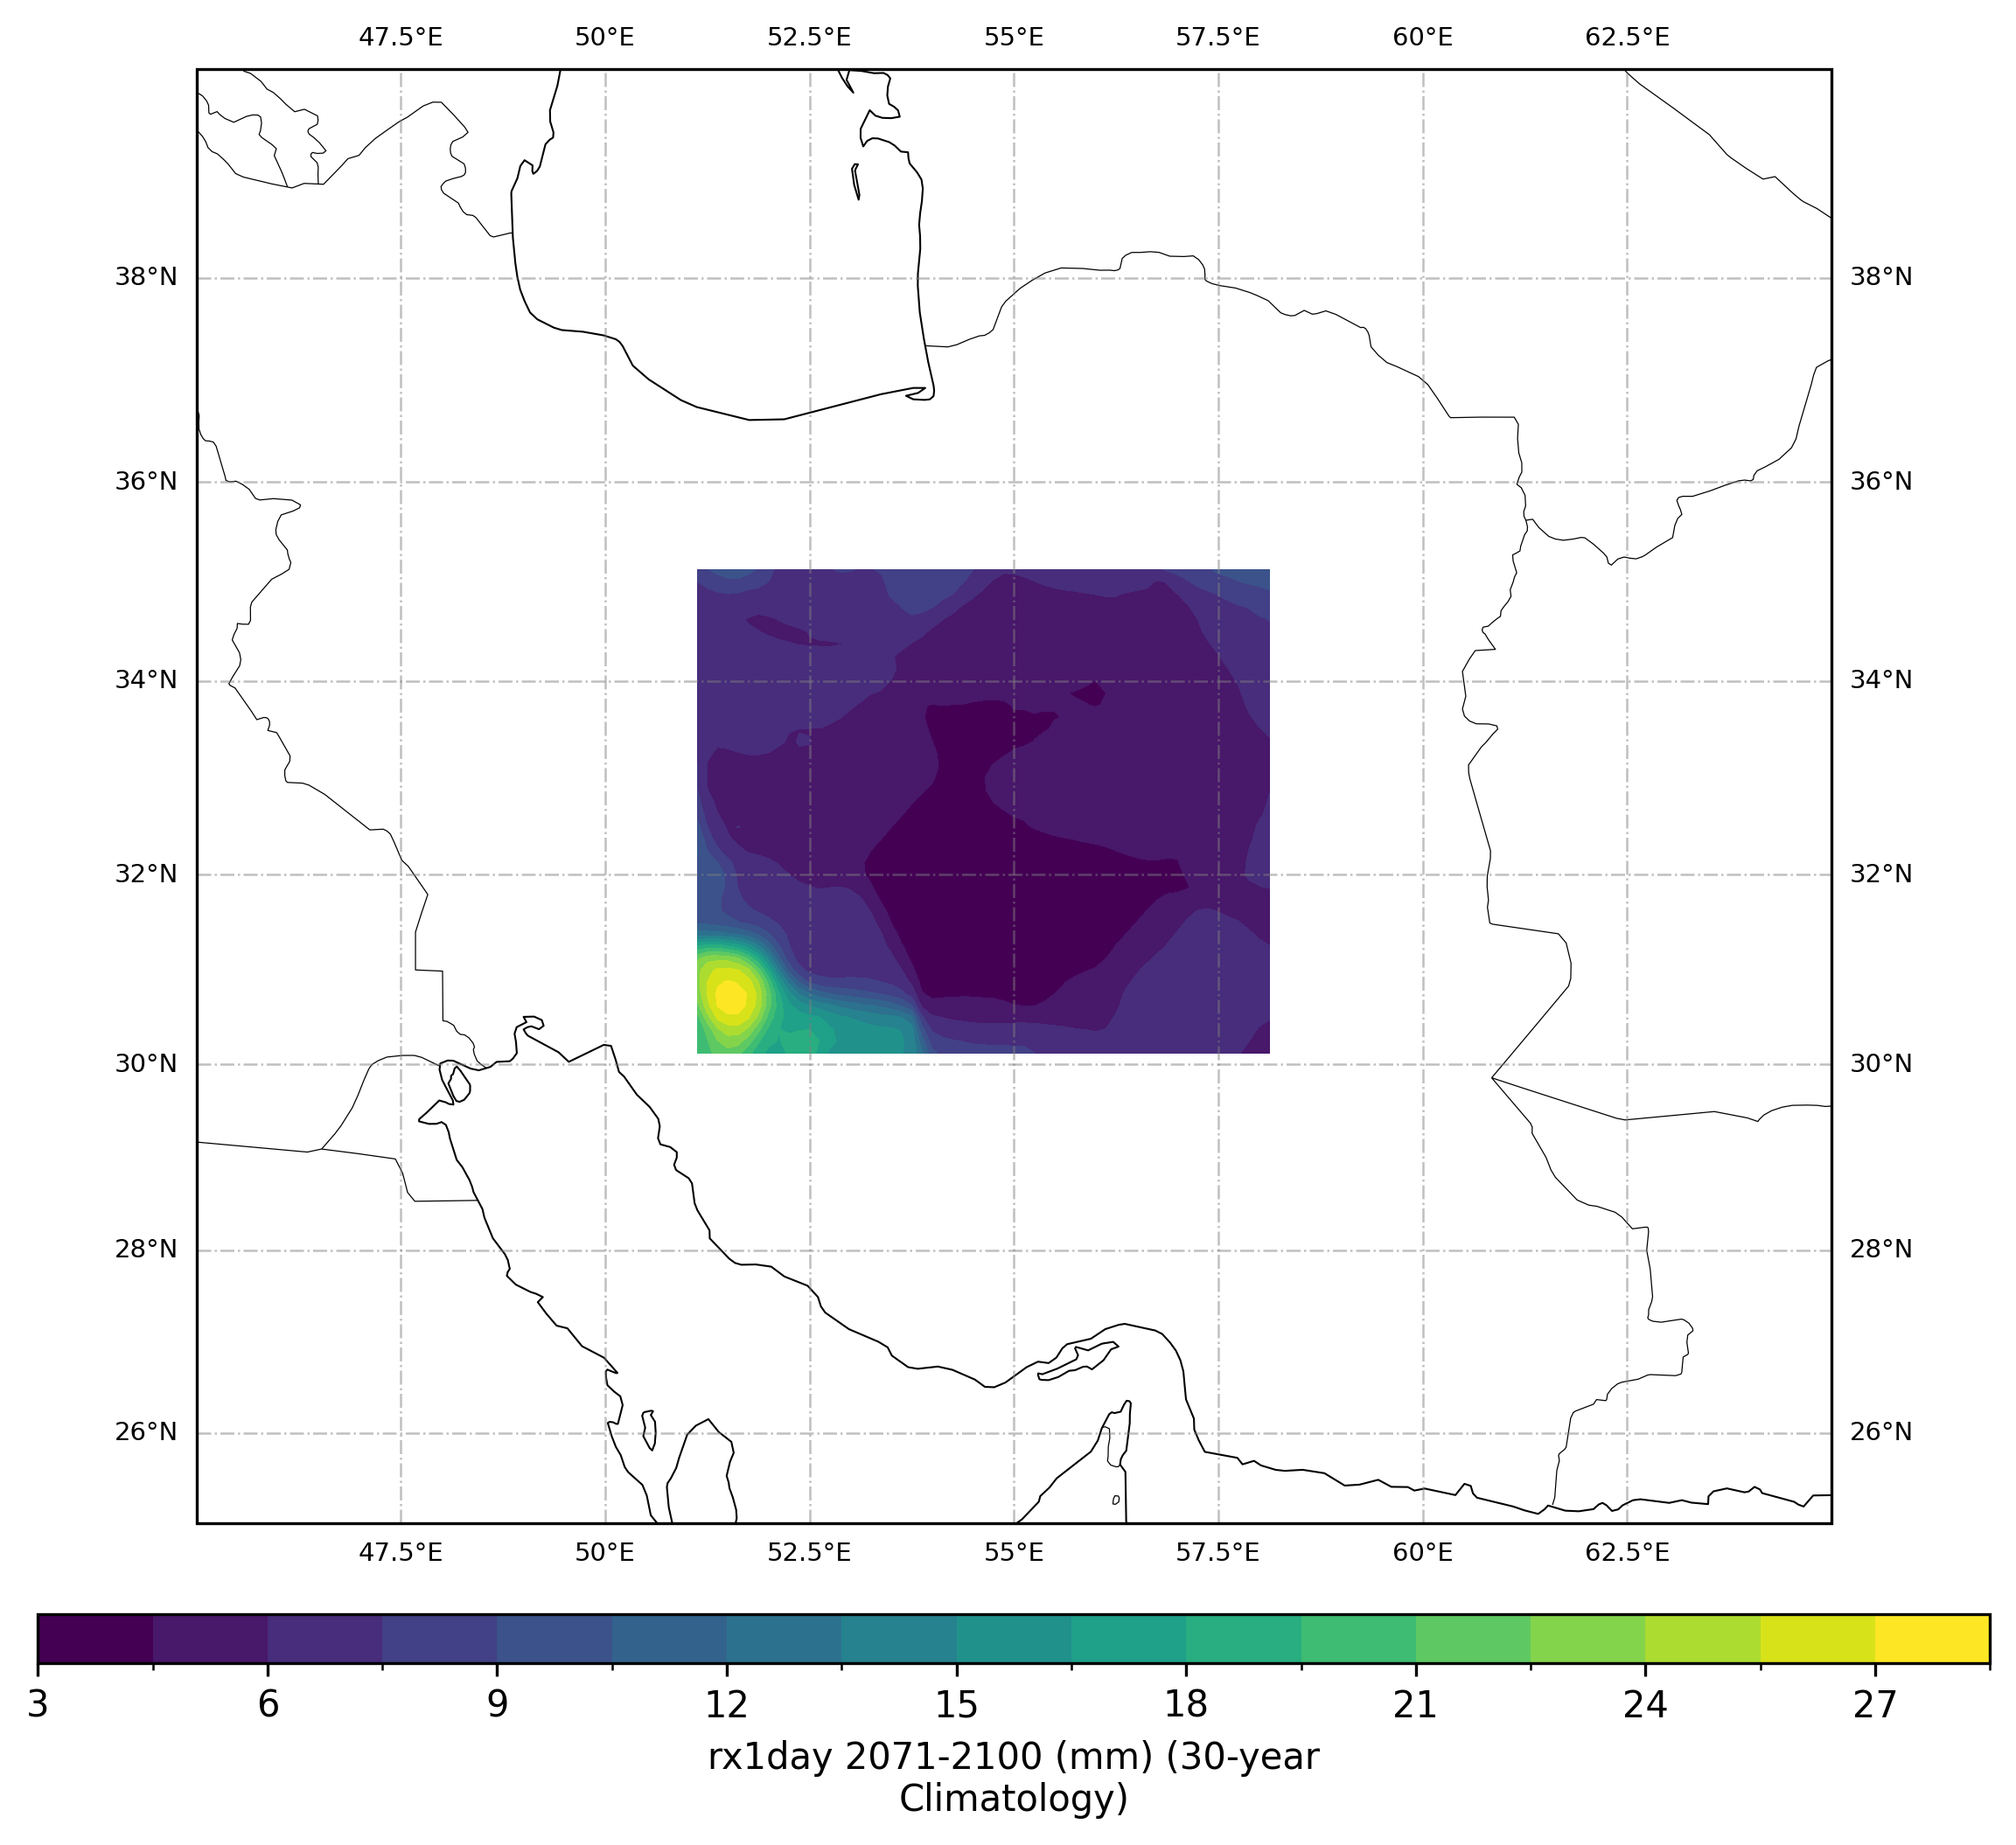

In [14]:
myPlot(rx1day_2071_2100_climatology)

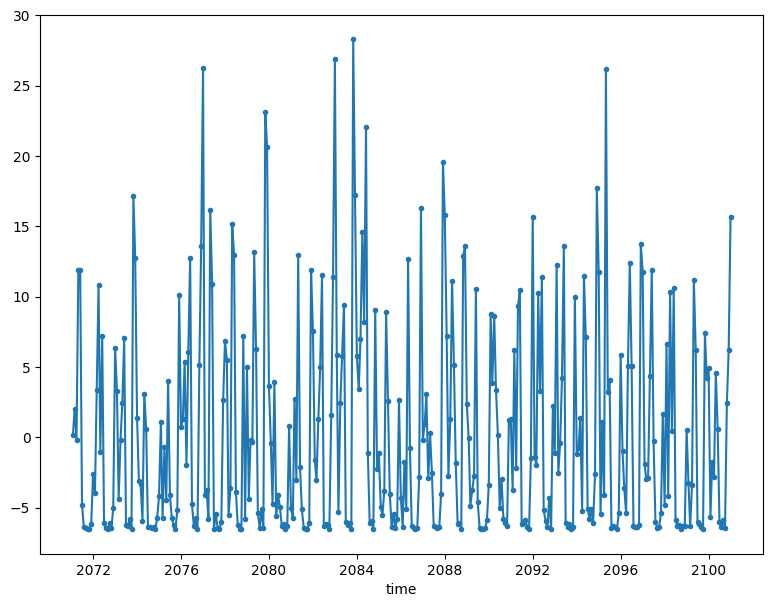

In [15]:
rx1day_2071_2100_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate CDD (1984-2015)

In [41]:
indices = pdex.indices(time_dim='time')
cdd_1984_2015 = indices.cdd(pr_1984_2015, period='1M', varname='pr')
cdd_1984_2015_climatology = cdd_1984_2015.mean(dim='time')
cdd_1984_2015_climatology.name = "cdd 1984-2015 (day) (30-year Climatology)"
cdd_1984_2015_anomaly = (cdd_1984_2015_climatology - cdd_1984_2015 )


c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


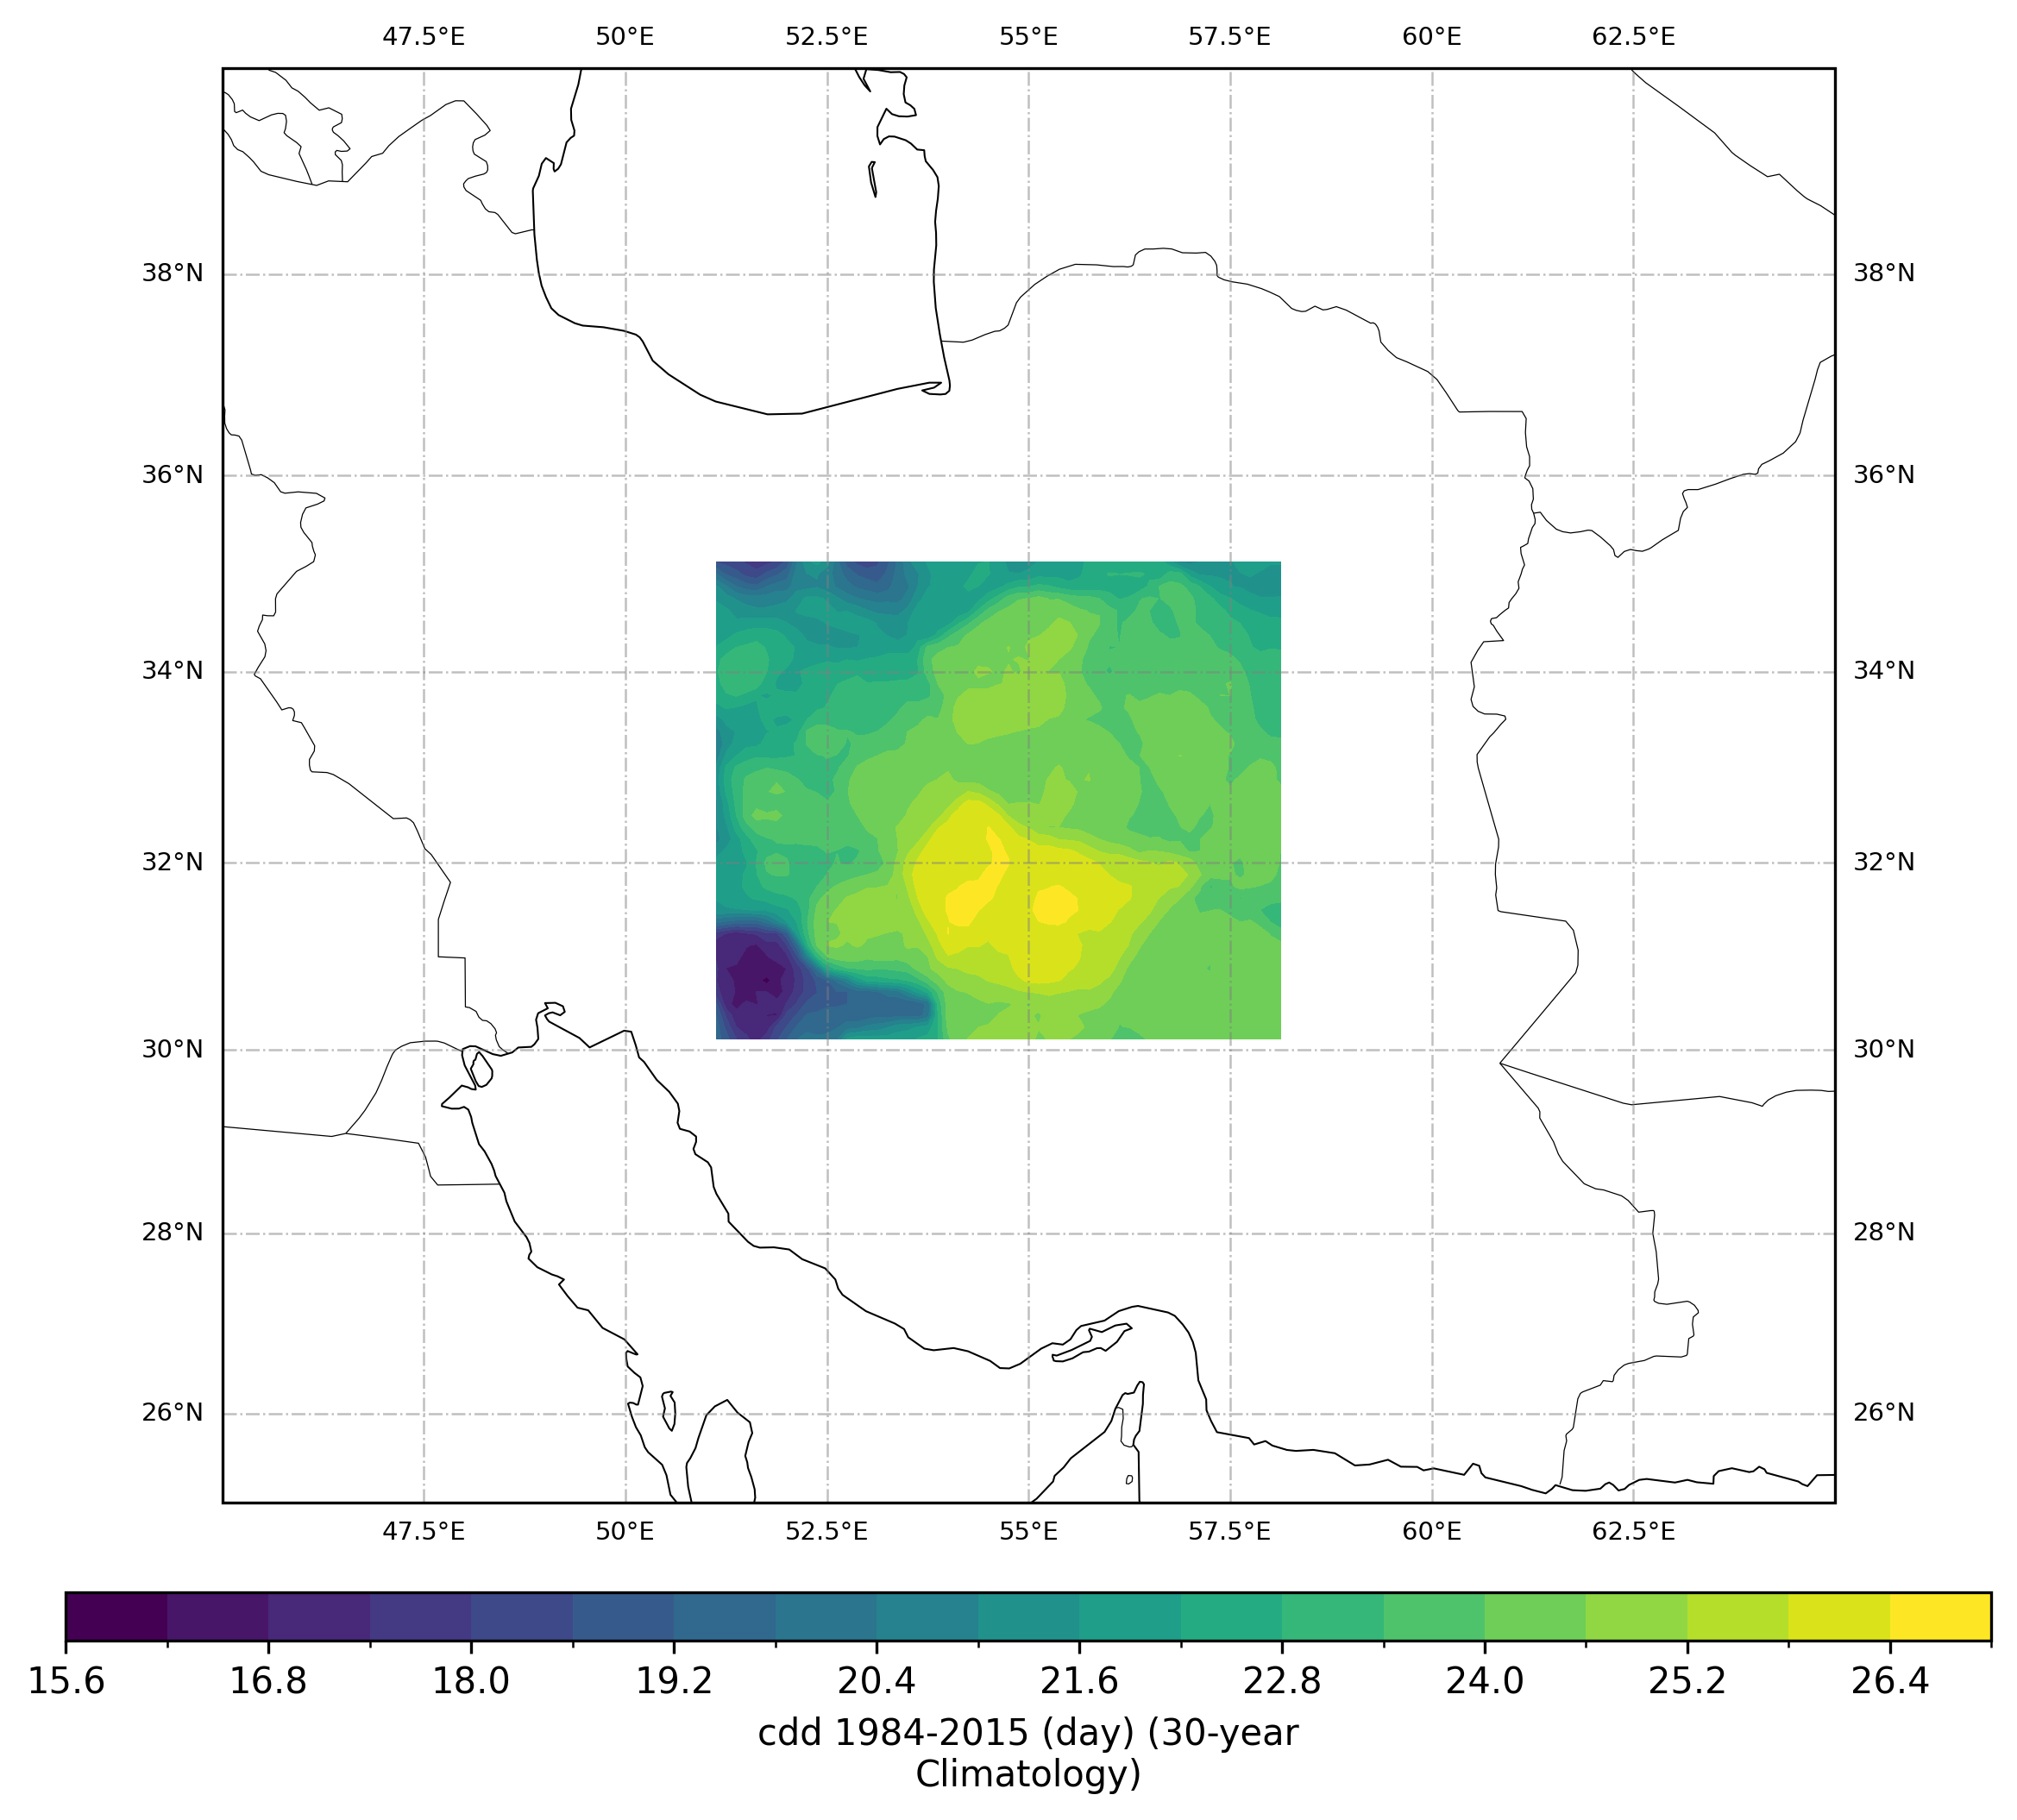

In [42]:
myPlot(cdd_1984_2015_climatology)

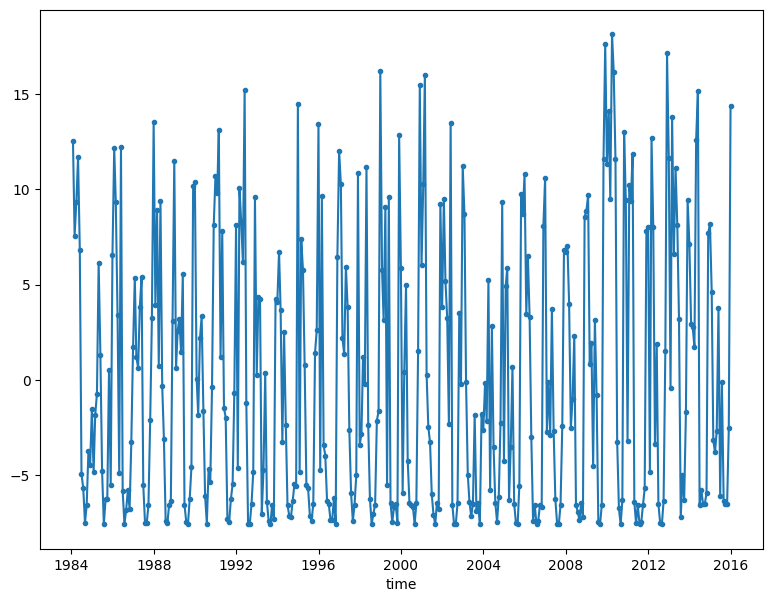

In [43]:
cdd_1984_2015_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate CDD (2071-2100)

In [44]:
indices = pdex.indices(time_dim='time')
cdd_2071_2100 = indices.cdd(pr_2071_2100, period='1M', varname='pr')
cdd_2071_2100_climatology = cdd_2071_2100.mean(dim='time')
cdd_2071_2100_climatology.name = "cdd 2071_2100 (day) (30-year Climatology)"
cdd_2071_2100_anomaly = (cdd_2071_2100_climatology - cdd_2071_2100)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


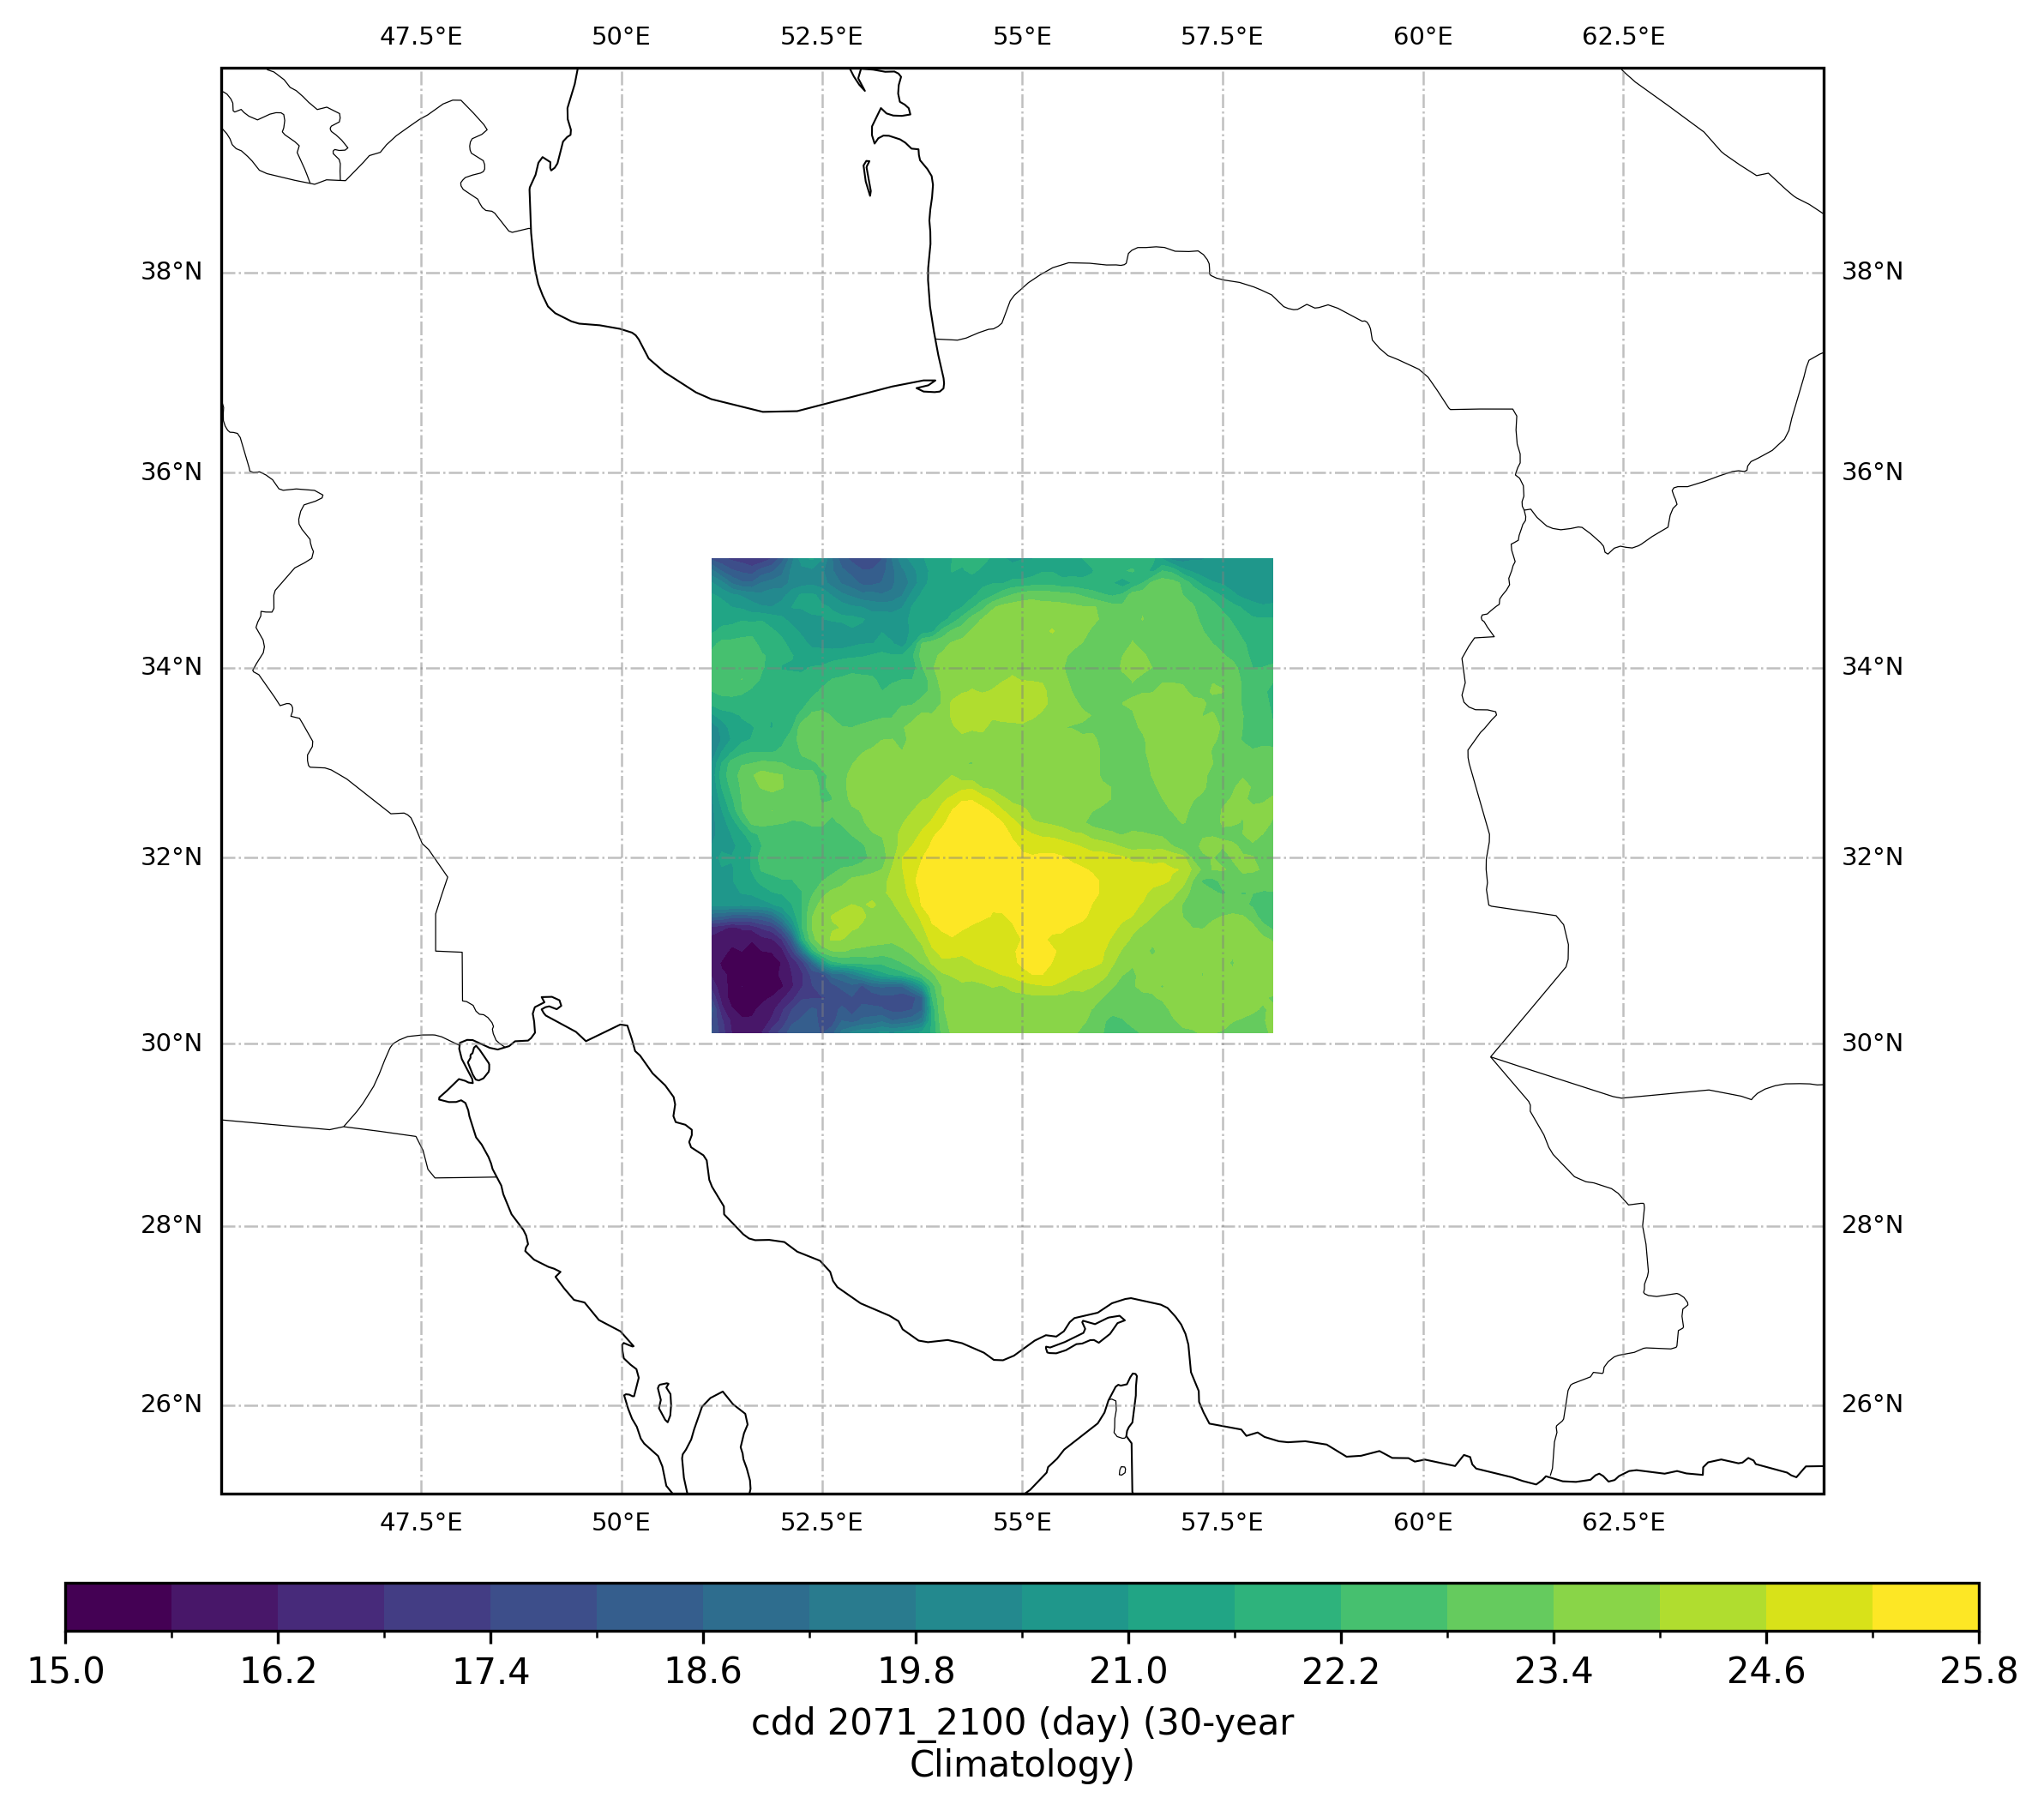

In [45]:
myPlot(cdd_2071_2100_climatology)

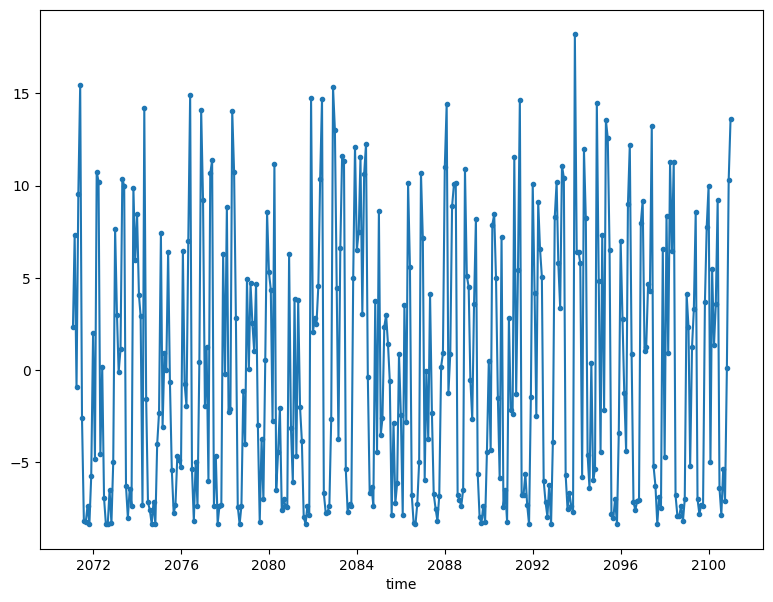

In [46]:
cdd_2071_2100_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate TXx (1984-2015)

In [59]:
indices = tdex.indices(time_dim='time')
txx_1984_2015 = indices.monthly_txx(tasmax_1984_2015, varname='tasmax')
txx_1984_2015_climatology = txx_1984_2015.mean(dim='time')
txx_1984_2015_climatology.name = "txx 1984_2015 (°C) (30-year Climatology)"
txx_1984_2015_anomaly = (txx_1984_2015 - txx_1984_2015_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


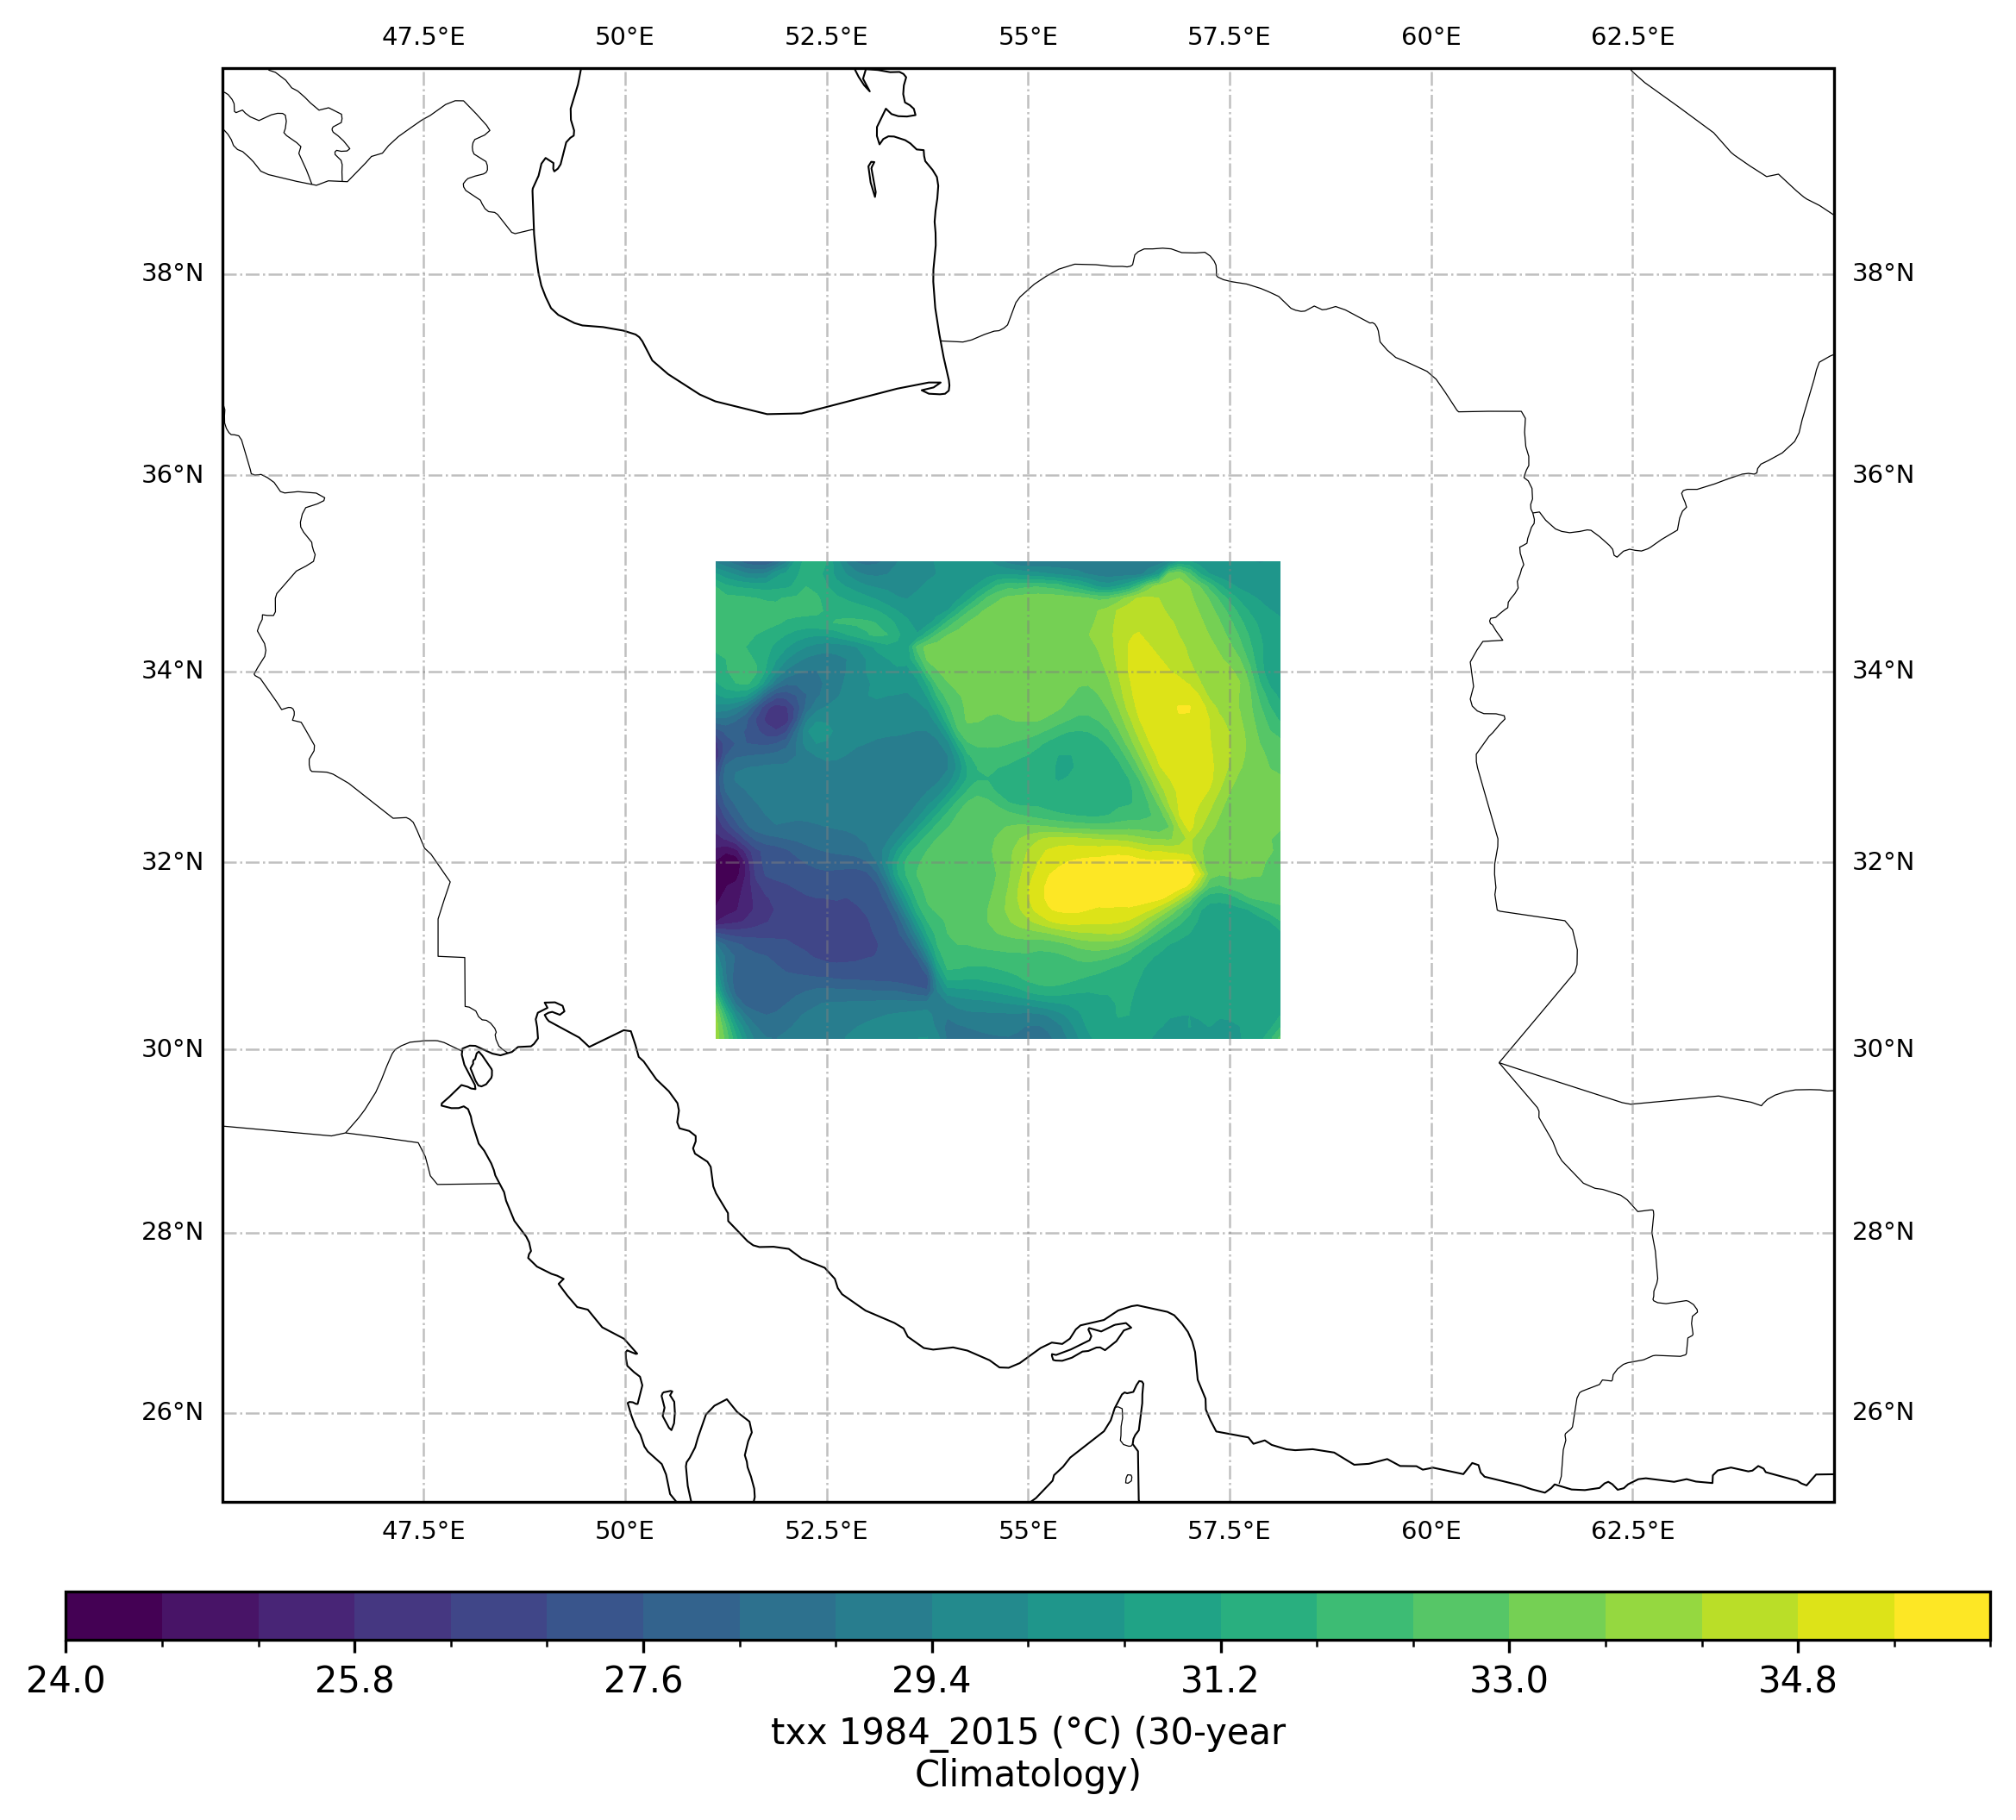

In [60]:
myPlot(txx_1984_2015_climatology)

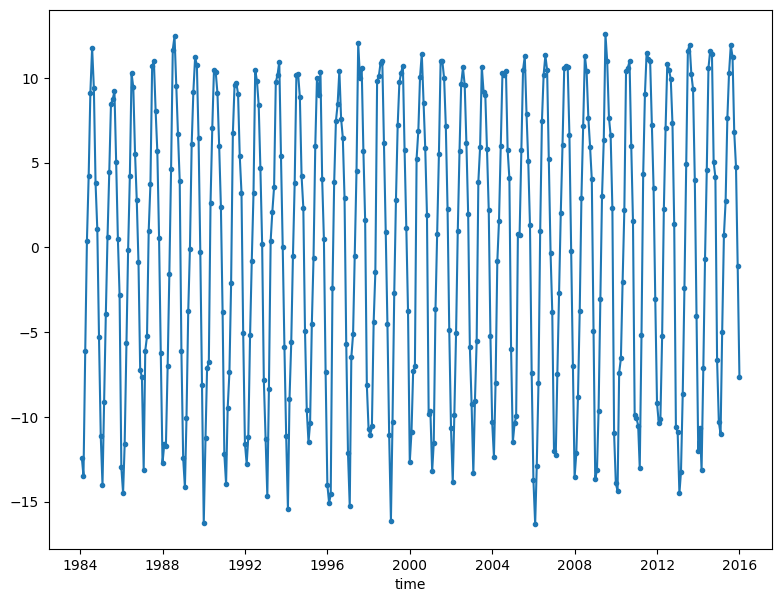

In [61]:
txx_1984_2015_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate TXx (2071-2100)

In [51]:
indices = tdex.indices(time_dim='time')
txx_2071_2100 = indices.monthly_txx(tasmax_2071_2100, varname='tasmax')
txx_2071_2100_climatology = txx_1984_2015.mean(dim='time')
txx_2071_2100_climatology.name = "txx 2071_2100 (°C) (30-year Climatology)"
txx_2071_2100_anomaly = (txx_2071_2100 - txx_2071_2100_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


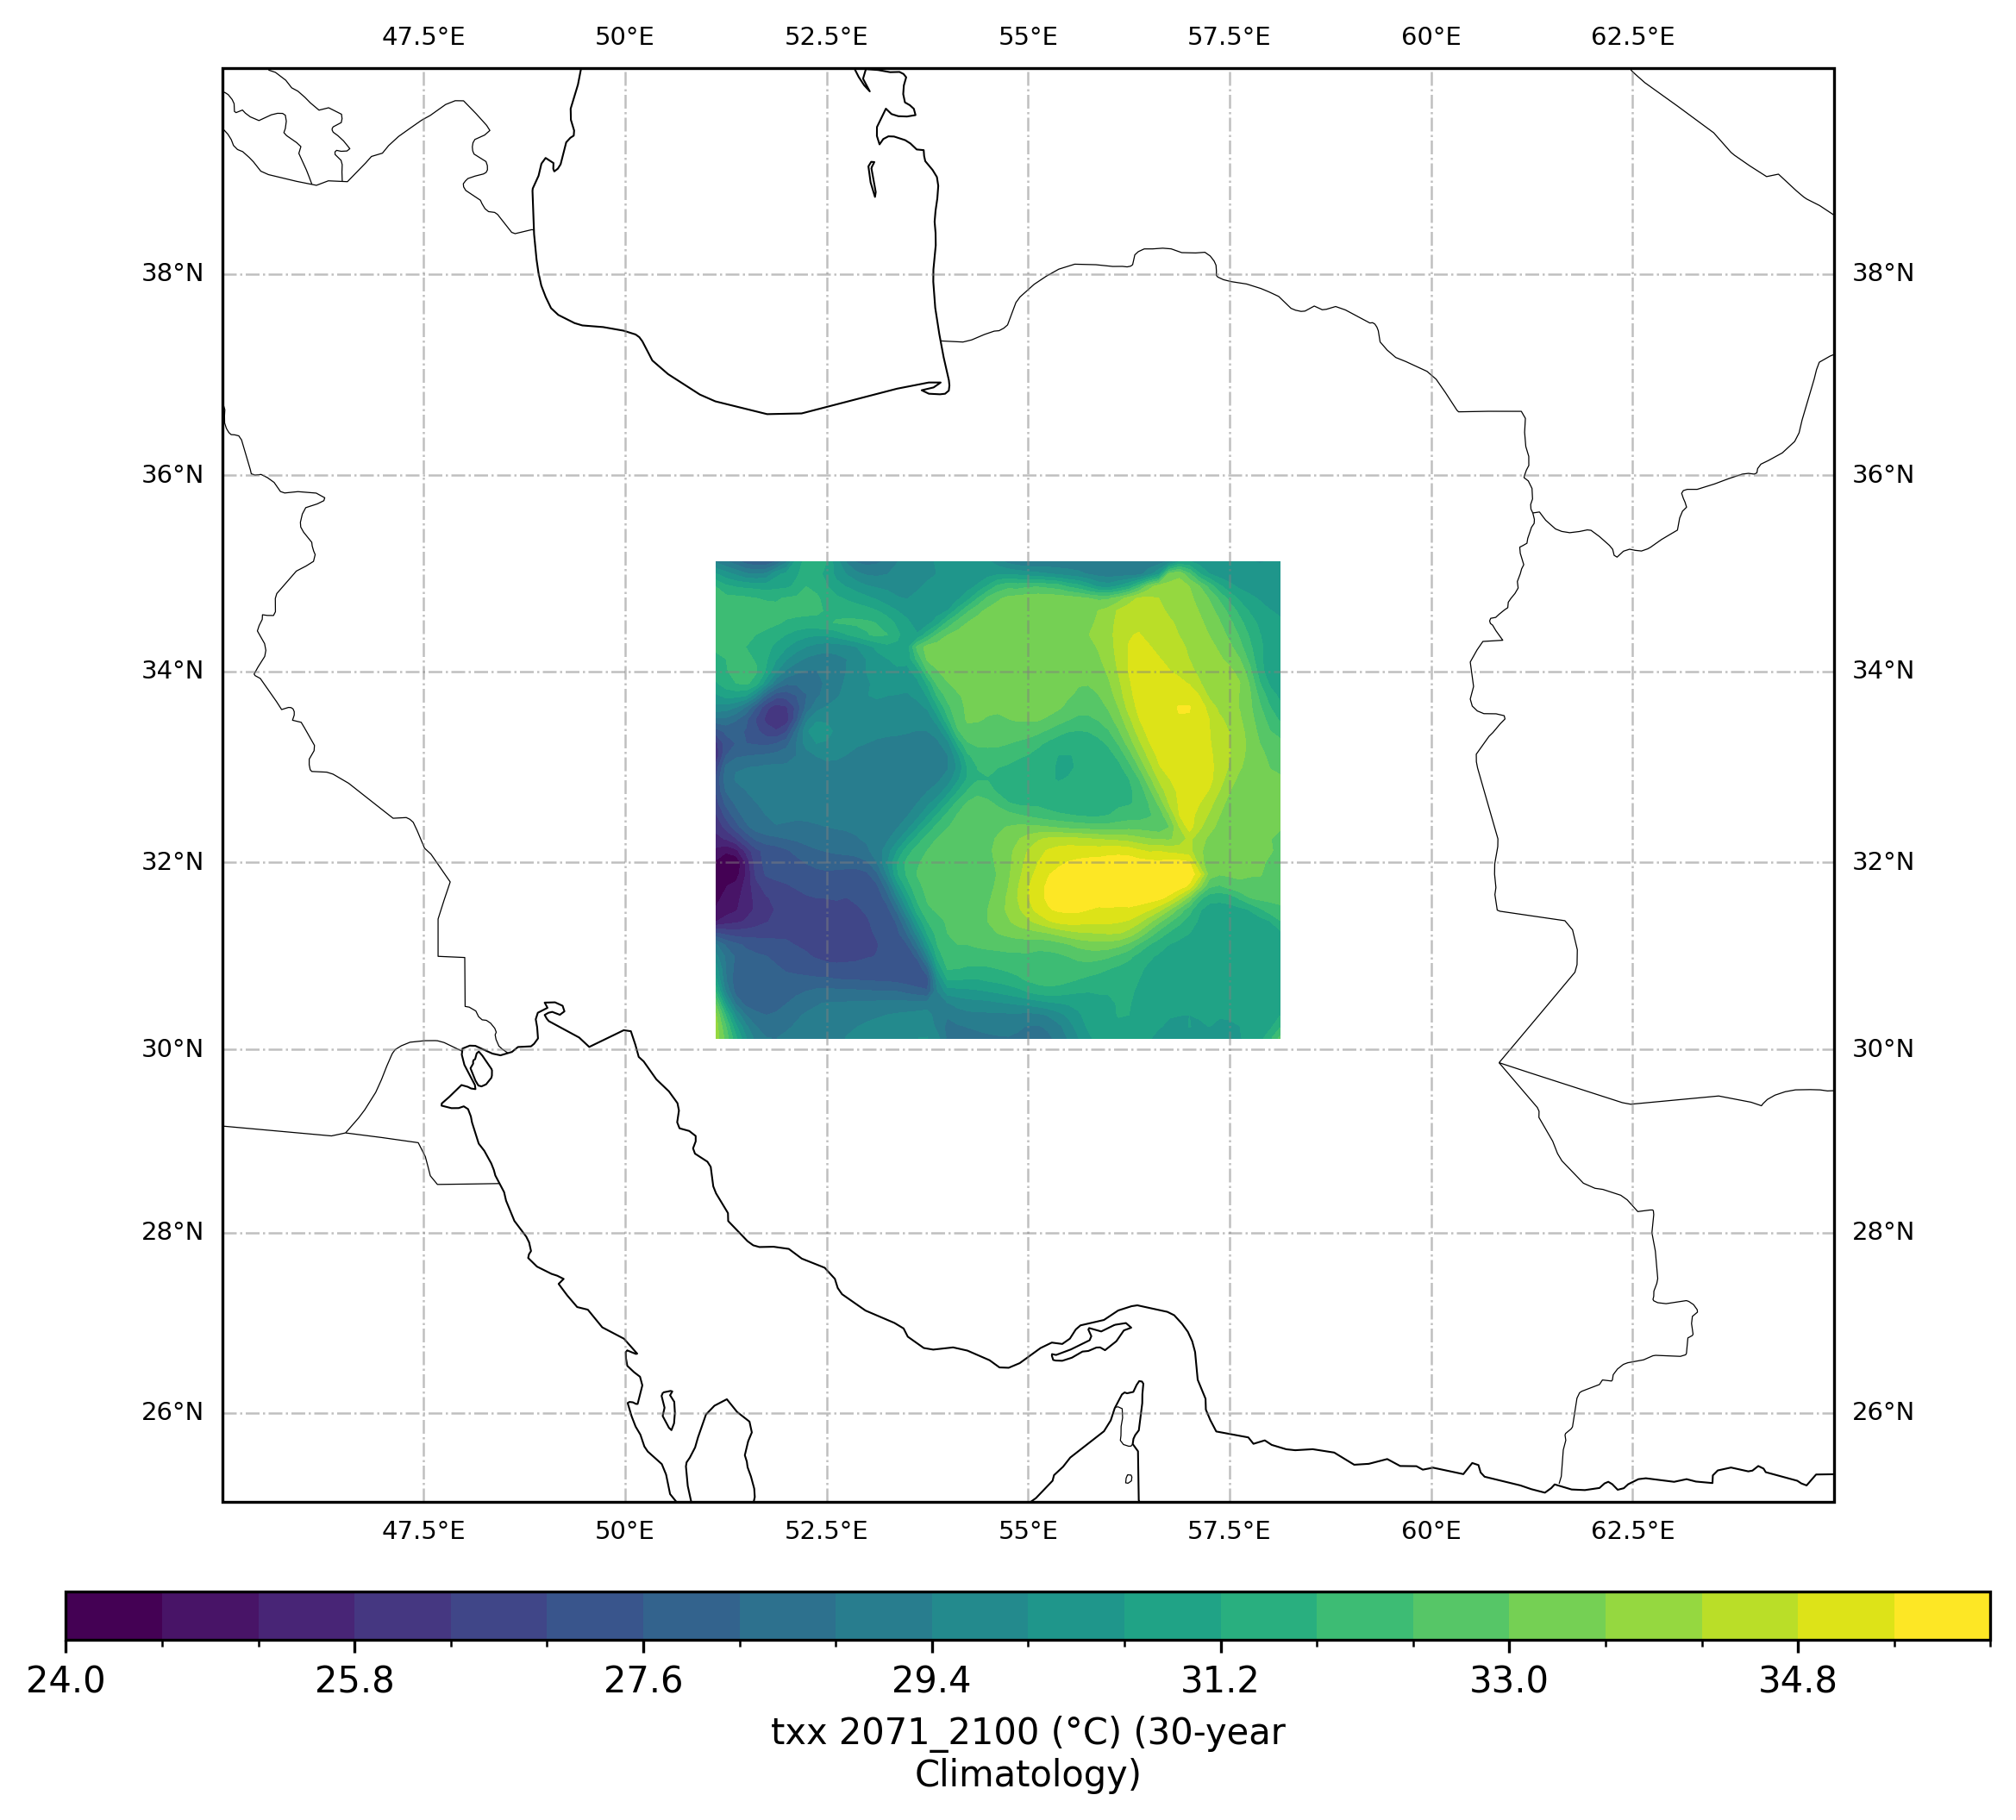

In [52]:
myPlot(txx_2071_2100_climatology)

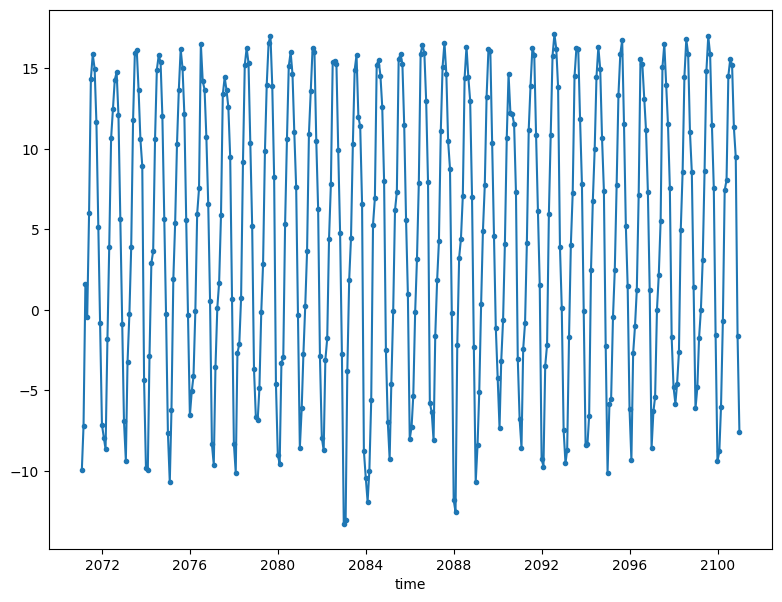

In [31]:
txx_2071_2100_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate TNn (1984-2015)

In [53]:
indices = tdex.indices(time_dim='time')
tnn_1984_2015 = indices.monthly_tnn(tasmin_1984_2015, varname='tasmin')
tnn_1984_2015_climatology = tnn_1984_2015.mean(dim='time')
tnn_1984_2015_climatology.name = "tnn 1984_2015 (°C) (30-year Climatology)"
tnn_1984_2015_anomaly = (tnn_1984_2015 - tnn_1984_2015_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


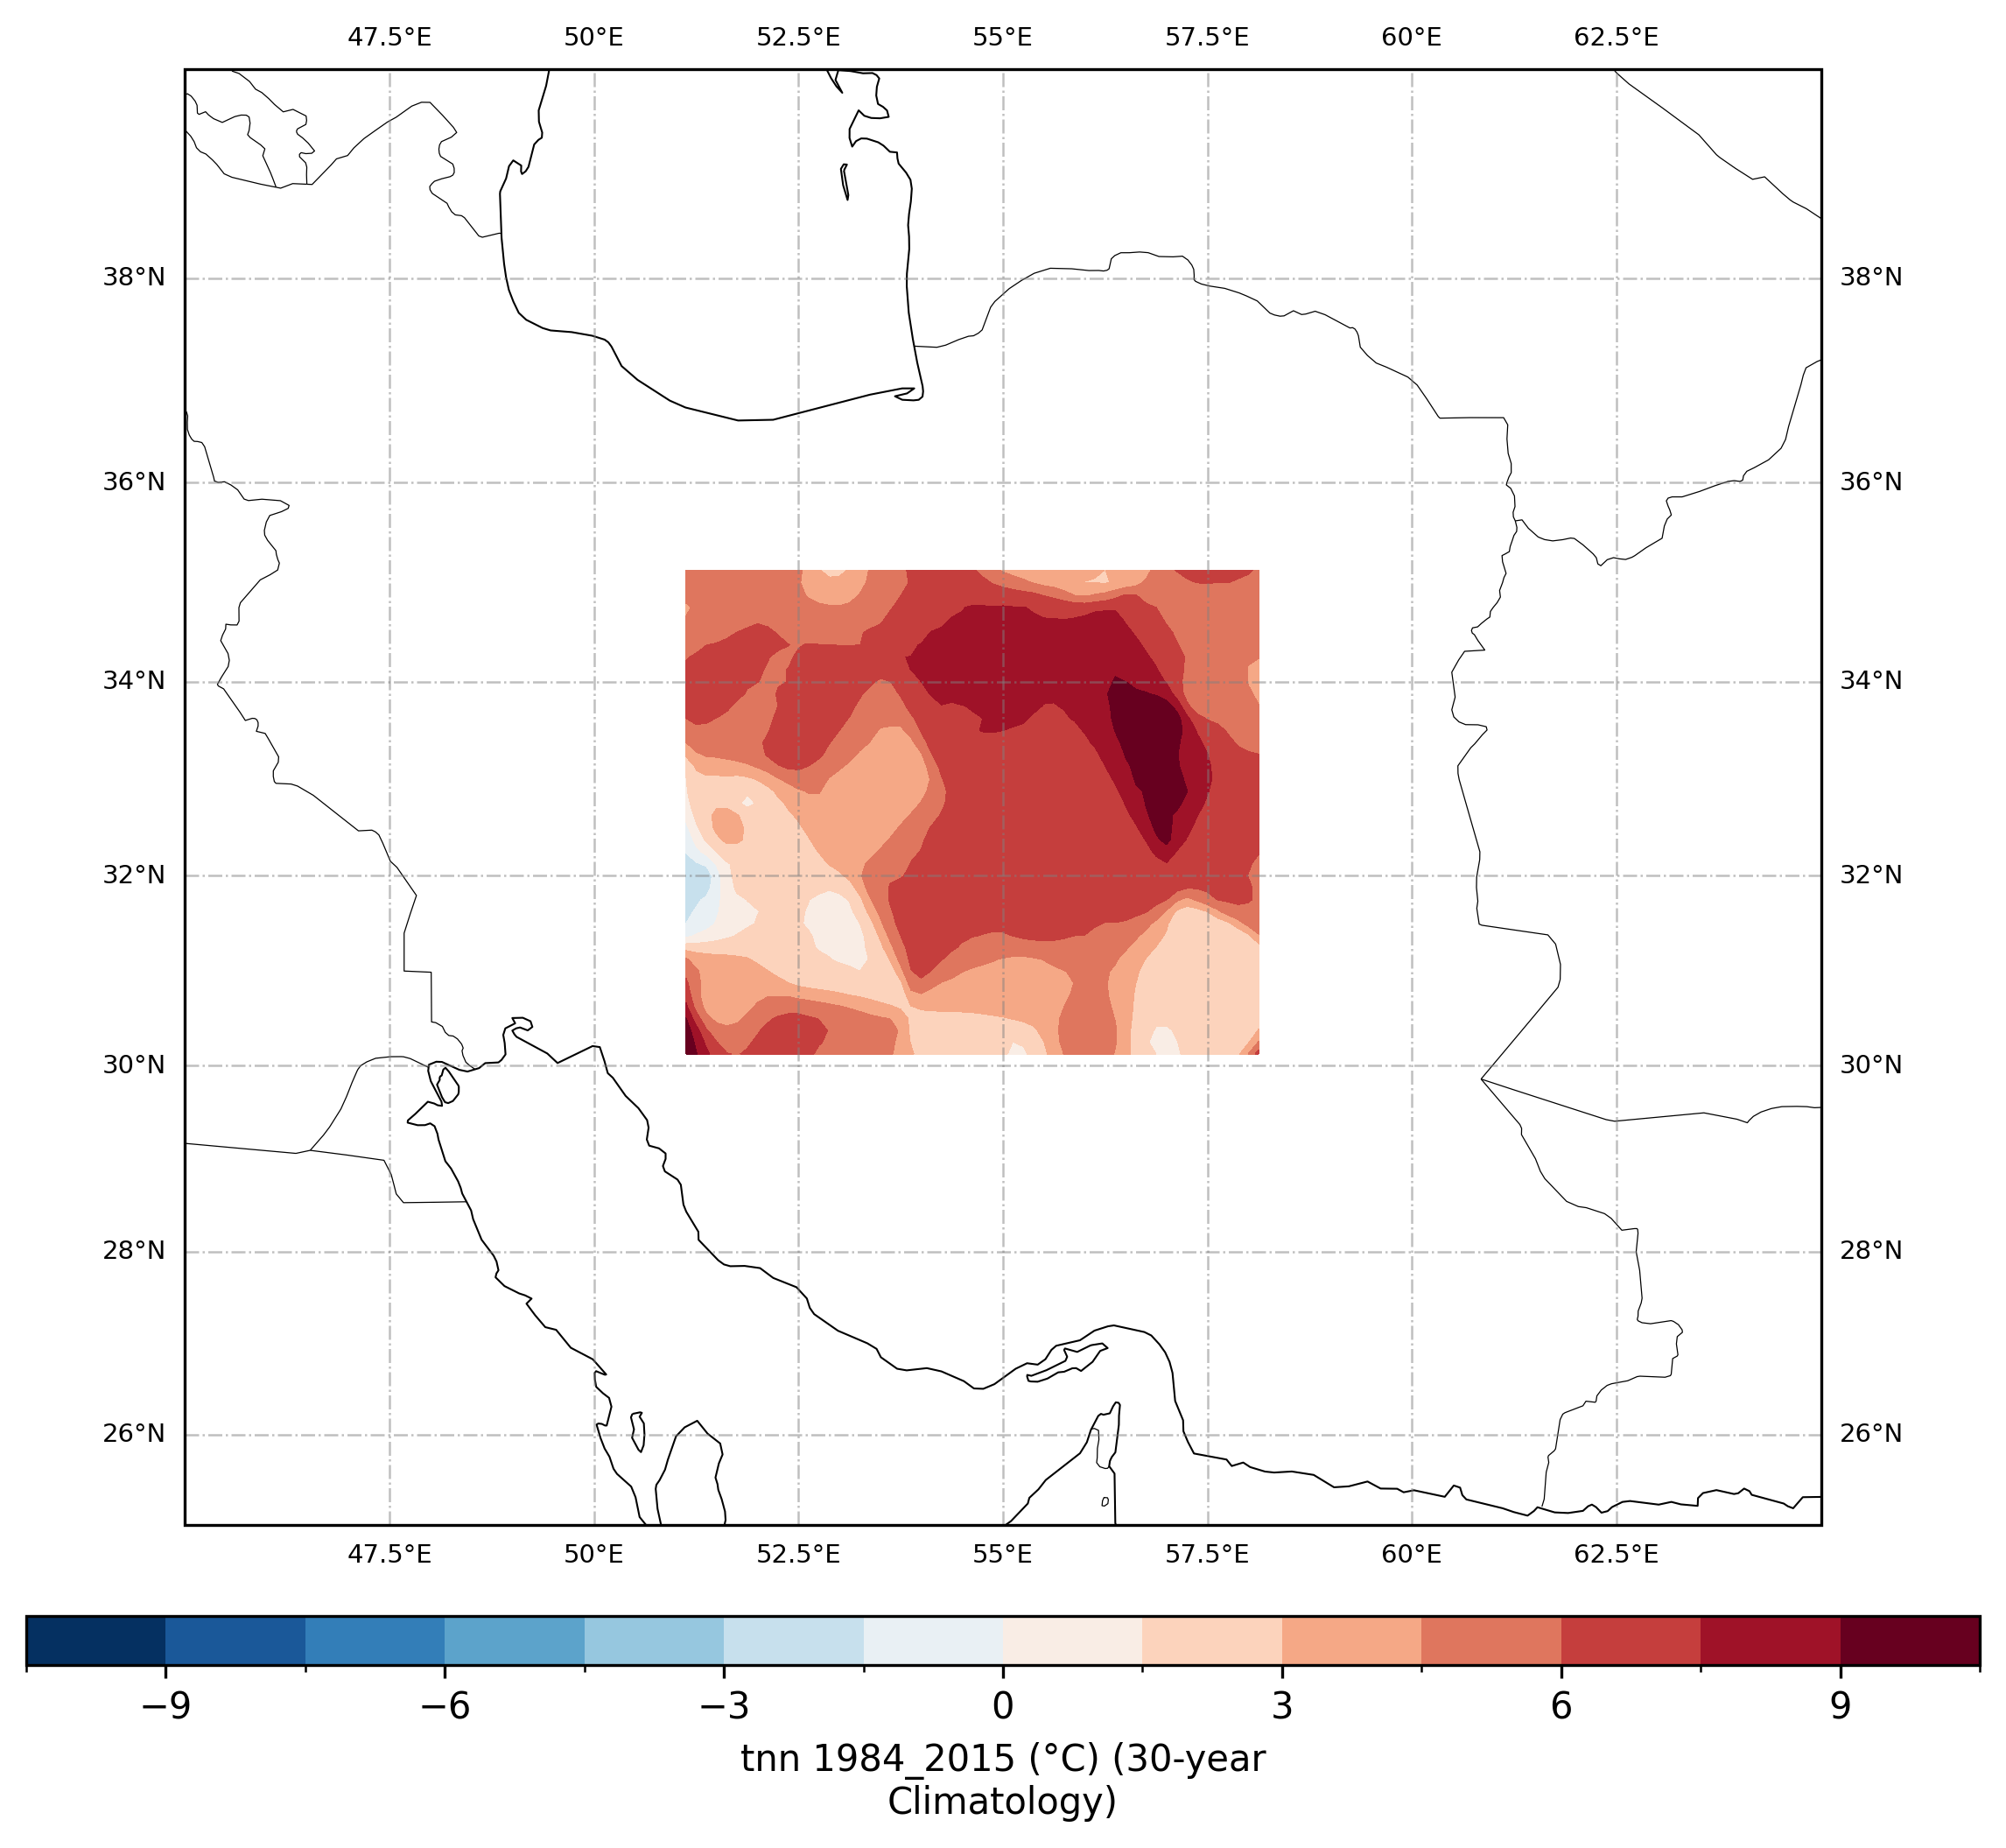

In [54]:
myPlot(tnn_1984_2015_climatology)

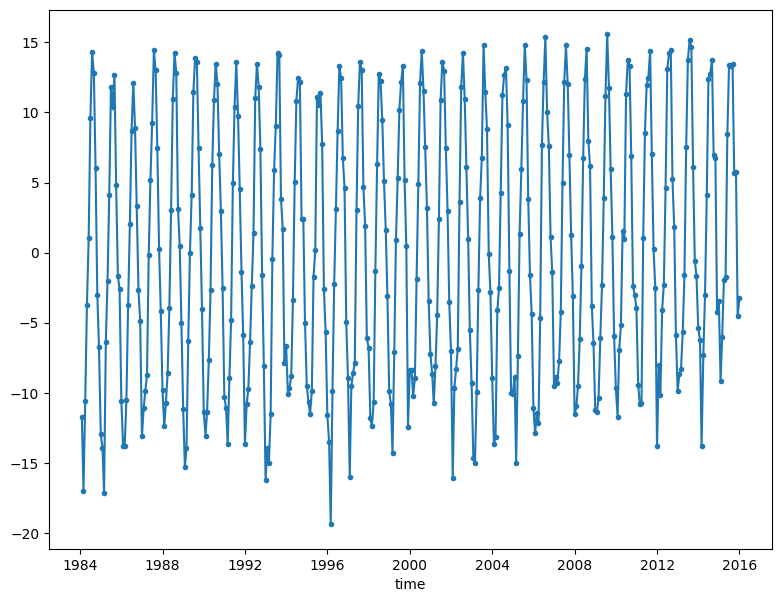

In [55]:
tnn_1984_2015_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)

# Calculate TNn (2071-2100)

In [56]:
indices = tdex.indices(time_dim='time')
tnn_2071_2100 = indices.monthly_tnn(tasmin_2071_2100, varname='tasmin')
tnn_2071_2100_climatology = tnn_2071_2100.mean(dim='time')
tnn_2071_2100_climatology.name = "tnn 1984_2015 (°C) (30-year Climatology)"
tnn_2071_2100_anomaly = (tnn_2071_2100 - tnn_2071_2100_climatology)

c:\Users\Beh.hd\Documents\w\climate-ex\.venv\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


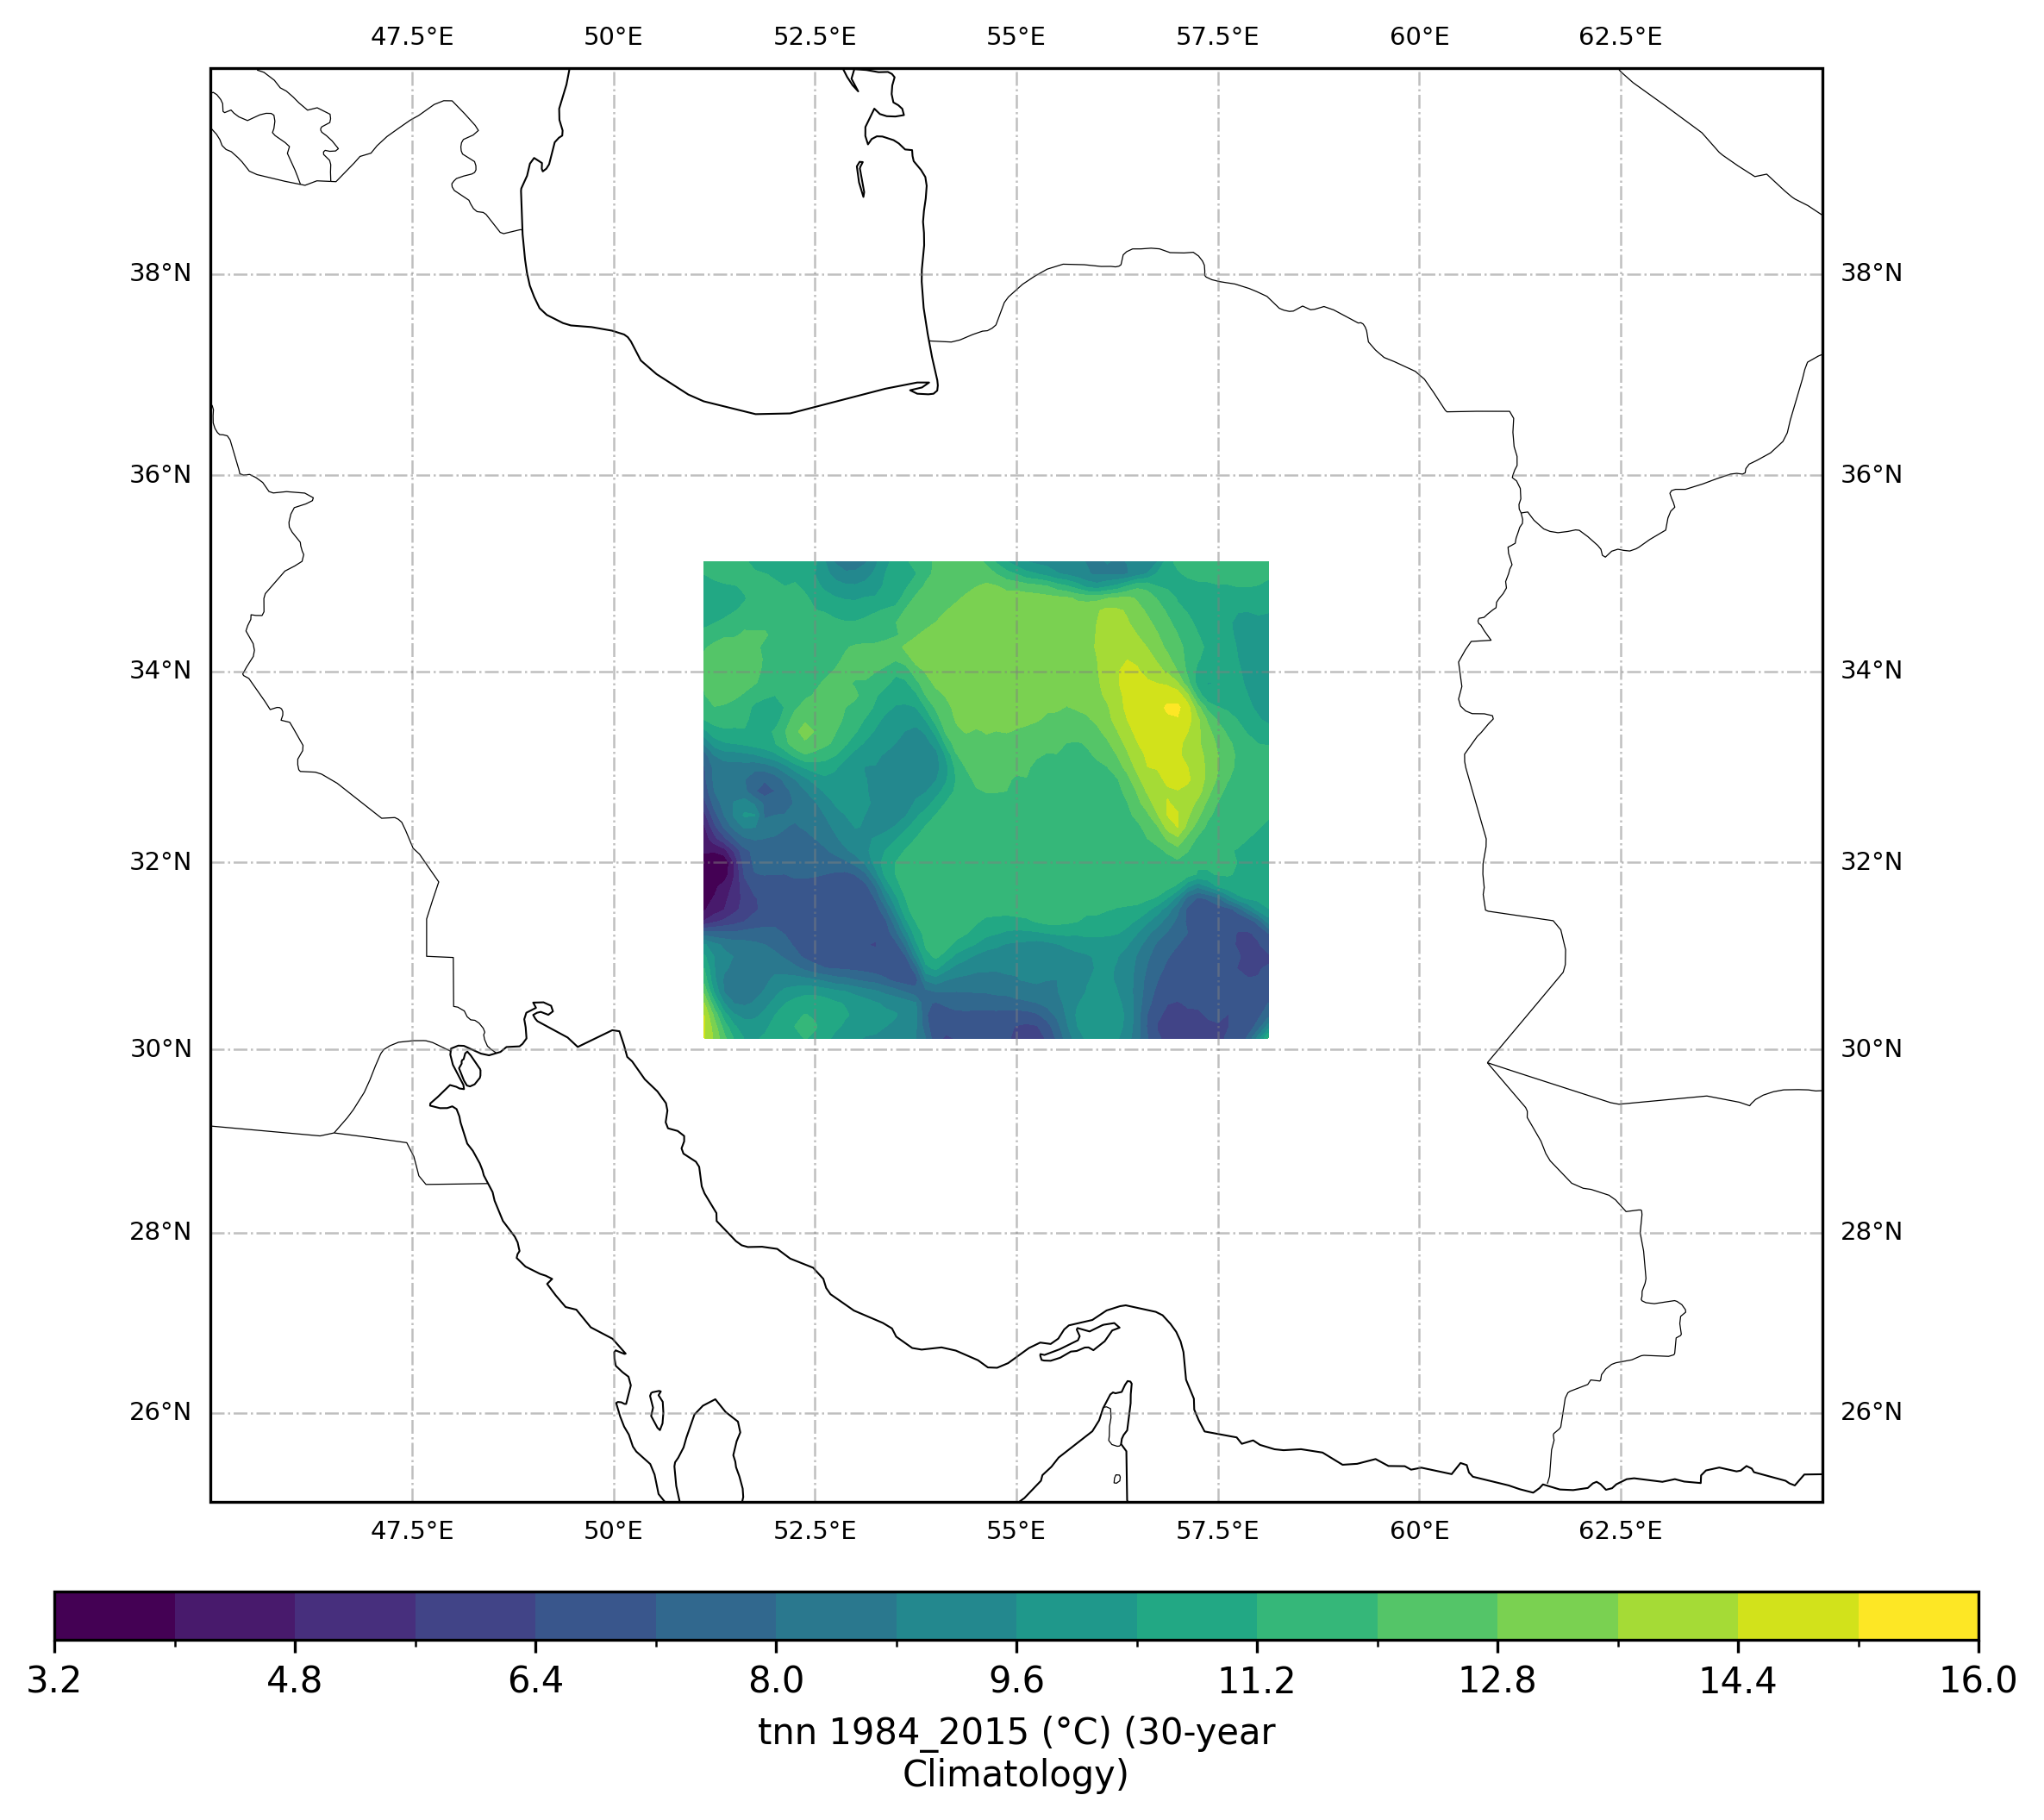

In [57]:
myPlot(tnn_2071_2100_climatology)

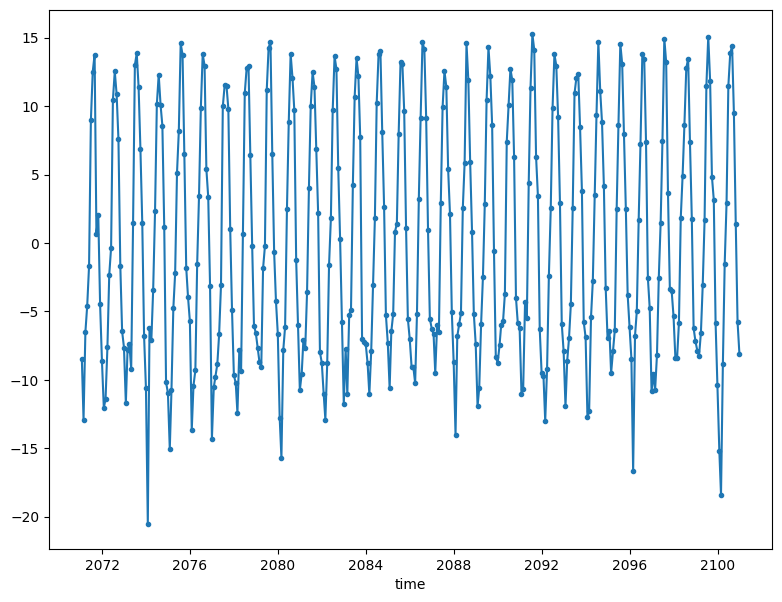

In [58]:
tnn_2071_2100_anomaly.mean(dim=('lat','lon')).plot(marker=".", size=7)